In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [4]:
receipts_df = pd.read_csv('raw_data/20241216_export_pharmacy_receiptdata_receipt.csv', dtype=str)
lineitems_df = pd.read_csv('raw_data/20241216_export_pharmacy_receiptdata_lineitem.csv', dtype={'amount': float, 'quantity': int, 'transaction_id': str, 'pzn': str})
products_df = pd.read_csv('raw_data/20241216_export_pharmacy_receiptdata_product.csv', header=None, names=['pzn', 'name'], dtype=str)

# types of the columns
print(receipts_df.dtypes)
print(lineitems_df.dtypes)
print(products_df.dtypes)

transaction_id    object
retailer_id       object
gln               object
zipcode_area      object
pos_id            object
timestamp         object
dtype: object
transaction_id     object
pzn                object
amount            float64
quantity            int64
dtype: object
pzn     object
name    object
dtype: object


#### <mark>In the file products.csv the column with the pzn numbers is now called "gtin" (global trade identification number), please change it to the name "pzn".</mark>

In [5]:
# Rename the column 'gtin' to 'pzn'
products_df.rename(columns={'gtin': 'pzn'}, inplace=True)

## Part 1: find any errors, missing data or duplicates

In [6]:
# Convert 'timestamp' to datetime for easier handling
receipts_df['timestamp'] = pd.to_datetime(receipts_df['timestamp'])

# Convert 'amount' from euro cents to euros -> note from the professor: "amount" is in euro cents
lineitems_df['amount'] = lineitems_df['amount'] / 100

In [7]:
# Check for duplicates in receipts
duplicates_receipts = receipts_df[receipts_df.duplicated()]
print(f"Duplicate receipts: {len(duplicates_receipts)}")

# Check for duplicates in line items
duplicates_lineitems = lineitems_df[lineitems_df.duplicated()]
print(f"Duplicate line items: {len(duplicates_lineitems)}")

Duplicate receipts: 0
Duplicate line items: 2756


In [8]:
# Drop duplicates
receipts_df.drop_duplicates(inplace=True)
lineitems_df.drop_duplicates(inplace=True)

In [9]:
# Check for negative prices
negative_prices = lineitems_df[lineitems_df['amount'] < 0]
print(f"Negative price entries: {len(negative_prices)}")

Negative price entries: 0


In [10]:
# Check for unrealistically high prices
high_prices = lineitems_df[lineitems_df['amount'] > 1000]
print(f"Unrealistically high price entries (amount > 1000): {len(high_prices)}")



Unrealistically high price entries (amount > 1000): 49


In [11]:
# check for very large amounts 
large_amounts = lineitems_df[lineitems_df['quantity'] > 100]
print(f"Unrealistically large quantity (quantity> 100): {len(large_amounts)}")

Unrealistically large quantity (quantity> 100): 79


In [12]:
print(f"quantity (> 100): {len(large_amounts)}")

# check for 90 - 100 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 90) & (lineitems_df['quantity'] <= 100)]
print(f"quantity (90 - 100): {len(large_amounts)}")

# check for 70 - 90 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 70) & (lineitems_df['quantity'] < 90)]
print(f"quantity (70 - 90): {len(large_amounts)}")

# check for 50 - 70 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 50) & (lineitems_df['quantity'] < 70)]
print(f"quantity (50 - 70): {len(large_amounts)}")

# check for 30 - 50 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 30) & (lineitems_df['quantity'] < 50)]
print(f"quantity (30 - 50): {len(large_amounts)}")

# check for 10 - 30 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 10) & (lineitems_df['quantity'] < 30)]
print(f"quantity (10 - 30): {len(large_amounts)}")

# check for 1 - 10 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 1) & (lineitems_df['quantity'] < 10)]
print(f"quantity (1 - 10): {len(large_amounts)}")

# check for 0 - 1 amounts
large_amounts = lineitems_df[lineitems_df['quantity'] == 0]
print(f" quantity (0): {len(large_amounts)}")

# check for < 0 amounts
large_amounts = lineitems_df[lineitems_df['quantity'] < 0]
print(f"quantity (< 0): {len(large_amounts)}")

quantity (> 100): 79
quantity (90 - 100): 40
quantity (70 - 90): 30
quantity (50 - 70): 165
quantity (30 - 50): 344
quantity (10 - 30): 6625
quantity (1 - 10): 12139976
 quantity (0): 0
quantity (< 0): 0


In [13]:
# delete line item with zero or negative amount
lineitems_df = lineitems_df[lineitems_df['amount'] > 0]

In [14]:
# Convert 'zipcode_area' to string
receipts_df['zipcode_area'] = receipts_df['zipcode_area'].astype(str)

codes = {}
# Find zip codes with different lengths
for length in range(1, 6):
    zipcodes = receipts_df[receipts_df['zipcode_area'].str.match(r'^\d{' + str(length) + '}$')]
    codes[length] = zipcodes
    print(f"{length}-digit zip codes: {len(zipcodes)}")
    print(zipcodes['zipcode_area'].unique()[:5])

# check for any bad zip codes that are not digits (1 - 5 digits)
bad_zipcodes = receipts_df[~receipts_df['zipcode_area'].str.match(r'^\d{1,5}$')]
print(f"Bad zip codes (not 1-5 digits): {len(bad_zipcodes)}")

1-digit zip codes: 0
[]
2-digit zip codes: 0
[]
3-digit zip codes: 6571356
['082' '312' '496' '254' '497']
4-digit zip codes: 0
[]
5-digit zip codes: 0
[]
Bad zip codes (not 1-5 digits): 0


In [15]:
# Handle Missing Entries
print(receipts_df.isnull().sum())
print('-' * 80)
print(lineitems_df.isnull().sum())
print('-' * 80)
print(products_df.isnull().sum())

transaction_id    0
retailer_id       0
gln               0
zipcode_area      0
pos_id            0
timestamp         0
dtype: int64
--------------------------------------------------------------------------------
transaction_id    0
pzn               0
amount            0
quantity          0
dtype: int64
--------------------------------------------------------------------------------
pzn     0
name    0
dtype: int64


- <mark>The prof mail says "Approx 12000 pzn are still missing in the product file" (confirmed)</mark>

In [16]:
# number of unique pnz in lineitems_df
print(f"Number of unique pzn in lineitems_df: {len(lineitems_df['pzn'].unique())}")
# number of unique pnz in products_df
print(f"Number of unique pzn in products_df: {len(products_df['pzn'].unique())}")

#  diff
diff = set(lineitems_df['pzn'].unique()) - set(products_df['pzn'].unique())
print(f"Number of unique pzn in lineitems_df but not in products_df: {len(diff)}")

Number of unique pzn in lineitems_df: 55004
Number of unique pzn in products_df: 46551
Number of unique pzn in lineitems_df but not in products_df: 11583


#### Data Merging and Integration

In [17]:
product_and_lineitems_df = lineitems_df.merge(products_df, on='pzn', how='inner')
print(f"Total number of line items in lineitems_df: {len(lineitems_df)}")
print(f"Total number of line items after merging with products: {len(product_and_lineitems_df)}")
print(f"Number of line items dropped during merge: {len(lineitems_df) - len(product_and_lineitems_df)}")

Total number of line items in lineitems_df: 12114349
Total number of line items after merging with products: 12047580
Number of line items dropped during merge: 66769


In [18]:
full_df = product_and_lineitems_df.merge(receipts_df, on='transaction_id', how='inner')

In [19]:
print(full_df.isnull().sum())

transaction_id    0
pzn               0
amount            0
quantity          0
name              0
retailer_id       0
gln               0
zipcode_area      0
pos_id            0
timestamp         0
dtype: int64


In [20]:
print("orignal number for line items: ", len(lineitems_df))
print("number after merge: ", len(product_and_lineitems_df))
print("number of line items that are missing the name in the products or the receipt (removed after the merge): ", len(lineitems_df) - len(product_and_lineitems_df))

orignal number for line items:  12114349
number after merge:  12047580
number of line items that are missing the name in the products or the receipt (removed after the merge):  66769


------

## Part 2: basic analysis for the lager dataset

#### number of different pharmacies

Total Unique Pharmacies           5804
Average Daily Active       1043.083562
Most Active Day             2024-06-25
Least Active Day            2023-04-07
dtype: object


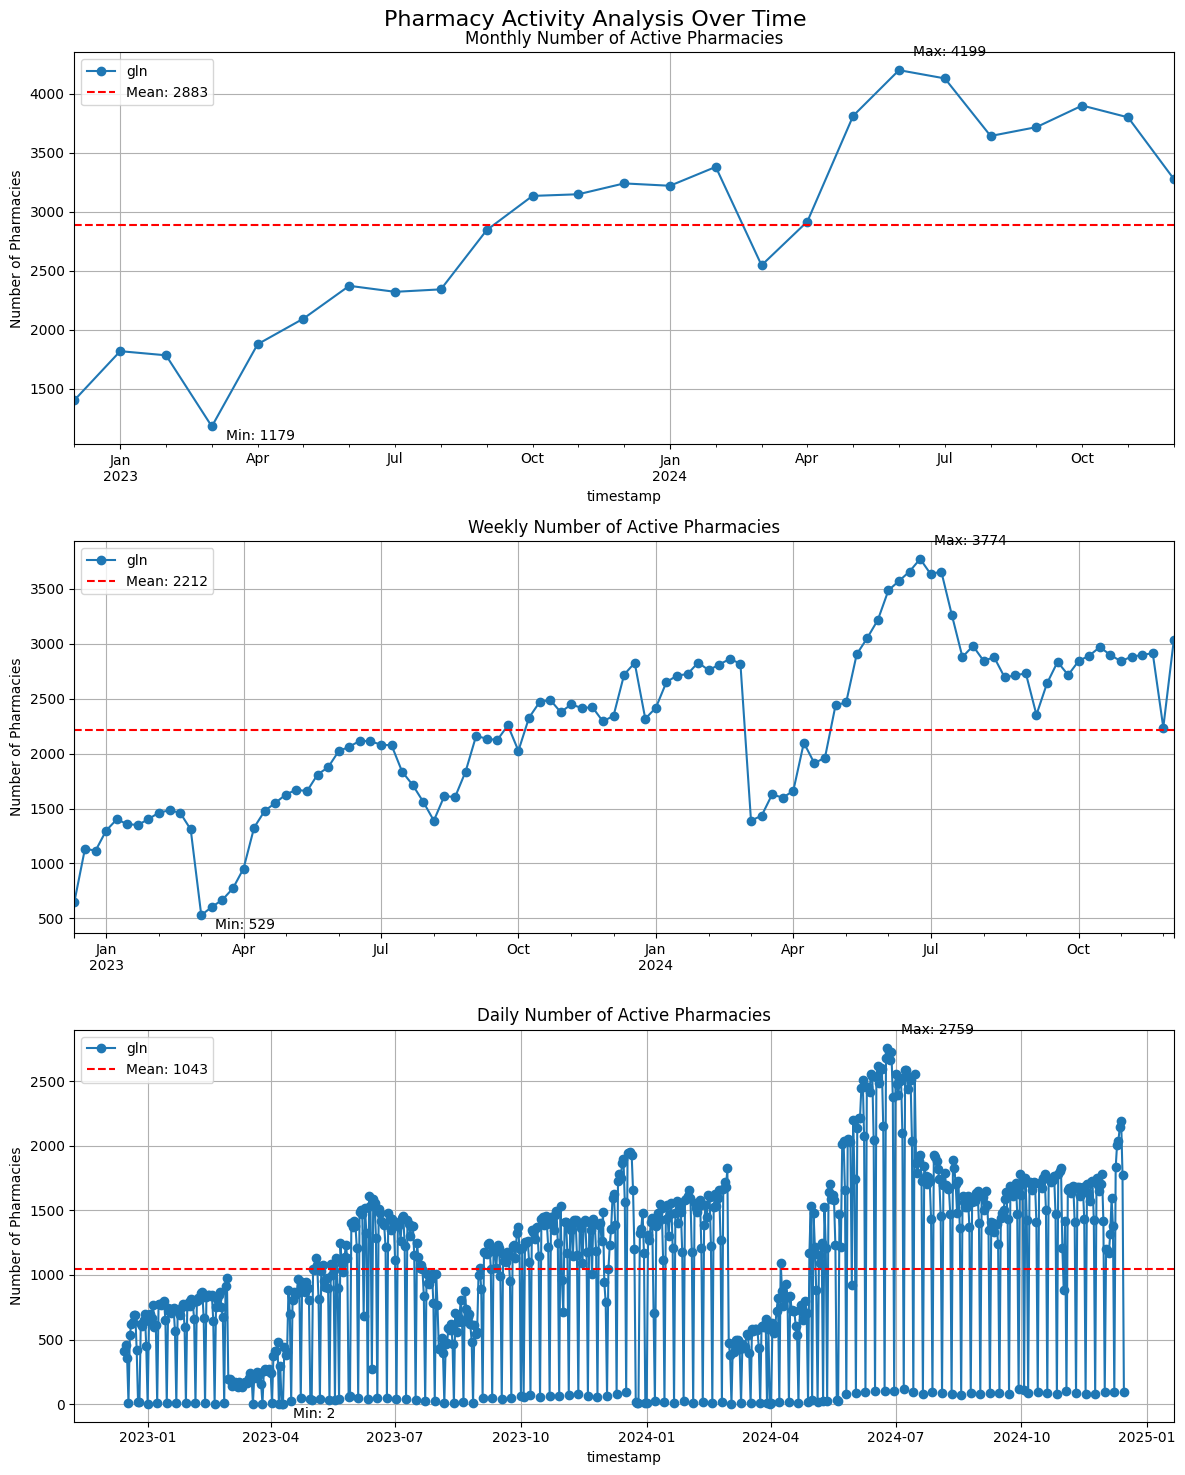

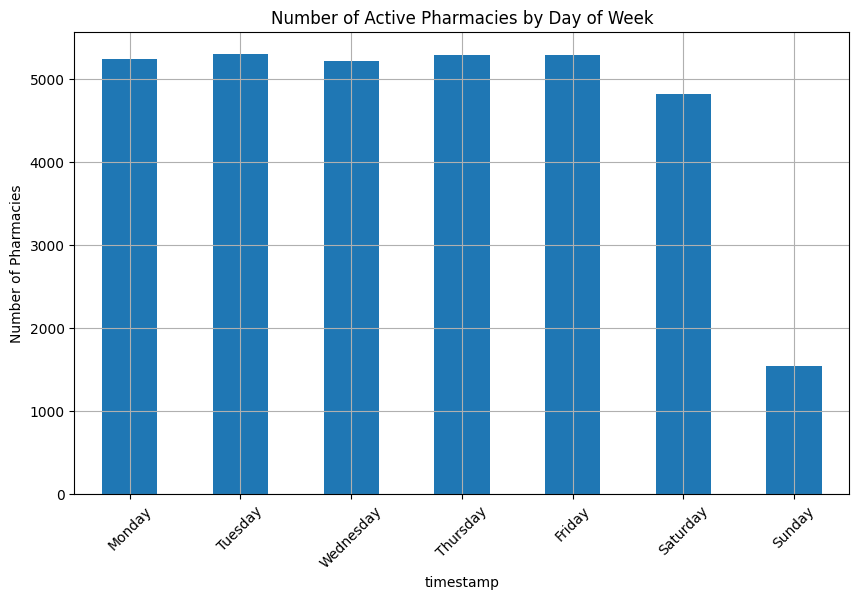

In [21]:
def analyze_pharmacies_over_time(df):
    # Set basic style parameters
    plt.rcParams['figure.figsize'] = (12, 15)
    plt.rcParams['axes.grid'] = True
    
    analyses = {
        'Monthly': df.groupby(df['timestamp'].dt.to_period('M'))['gln'].nunique(),
        'Weekly': df.groupby([df['timestamp'].dt.isocalendar().year, # Group by year-week, week only will not work as it will group weeks from different years together
                            df['timestamp'].dt.isocalendar().week])['gln'].nunique(),
        'Daily': df.groupby(df['timestamp'].dt.date)['gln'].nunique()
    }
    
    fig, axes = plt.subplots(3, 1)
    fig.suptitle('Pharmacy Activity Analysis Over Time', fontsize=16)
    
    for ax, (period, data) in zip(axes, analyses.items()):
        if period == 'Weekly':
            # Convert year-week to datetime
            dates = []
            for year, week in data.index:
                # Create a date object for the first day of the year
                first_day = pd.Timestamp(f"{year}-01-01")
                # Find the first Monday of the year
                monday = first_day + pd.Timedelta(days=(7 - first_day.weekday()) % 7)
                # Add the weeks
                dates.append(monday + pd.Timedelta(weeks=week-1))
            data.index = dates
        
        data.plot(ax=ax, marker='o', color='#1f77b4')
        ax.set_title(f'{period} Number of Active Pharmacies')
        ax.set_ylabel('Number of Pharmacies')
        
        mean_val = data.mean()
        ax.axhline(y=mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.0f}')
        
        max_val = data.max()
        min_val = data.min()
        ax.annotate(f'Max: {max_val}', 
                   xy=(data.idxmax(), max_val),
                   xytext=(10, 10),
                   textcoords='offset points')
        ax.annotate(f'Min: {min_val}',
                   xy=(data.idxmin(), min_val),
                   xytext=(10, -10),
                   textcoords='offset points')
        
        ax.legend(loc='upper left')

    plt.tight_layout()
    return fig, analyses

# Analyze the number of active pharmacies over days of the week
def analyze_pharmacy_day_patterns(df):
    # group by day of the week and count the unique pharmacies (day name)
    day_patterns = df.groupby(df['timestamp'].dt.day_name())['gln'].nunique()
    # Order the days of the week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    # Reindex the series to have the days in order
    day_patterns = day_patterns.reindex(day_order)
    
    plt.figure(figsize=(10, 6))
    ax = day_patterns.plot(kind='bar', color='#1f77b4')
    plt.title('Number of Active Pharmacies by Day of Week')
    plt.ylabel('Number of Pharmacies')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    
    return day_patterns

# Get some basic statistics about the pharmacies
def get_pharmacy_stats(df):
    return pd.Series({
        'Total Unique Pharmacies': df['gln'].nunique(),
        'Average Daily Active': df.groupby(df['timestamp'].dt.date)['gln'].nunique().mean(),
        'Most Active Day': df.groupby(df['timestamp'].dt.date)['gln'].nunique().idxmax(),
        'Least Active Day': df.groupby(df['timestamp'].dt.date)['gln'].nunique().idxmin(),
    })


# Run the analysis
fig, analyses = analyze_pharmacies_over_time(full_df)
day_patterns = analyze_pharmacy_day_patterns(full_df)
stats = get_pharmacy_stats(full_df)
print(stats)

#### analyze_receipts

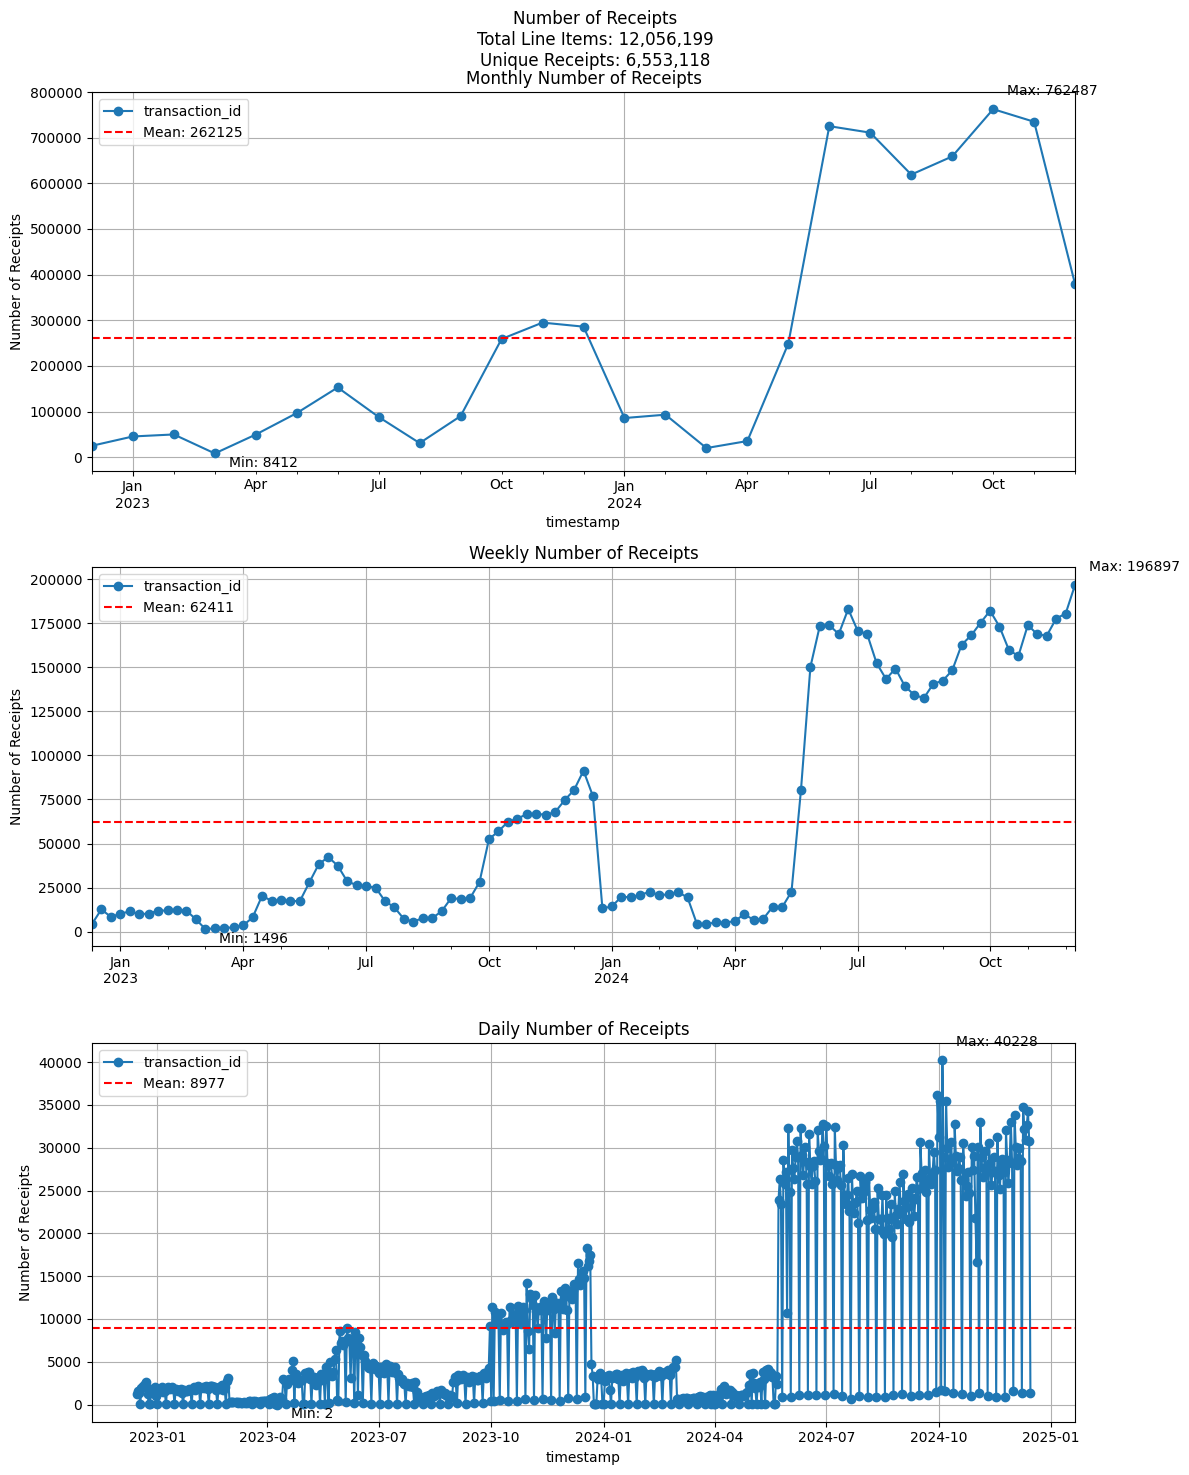

In [22]:
def analyze_receipts(df):
    total_line_items = len(df)
    unique_receipts = df['transaction_id'].nunique()
    
    analyses = {
        'Monthly': df.groupby(df['timestamp'].dt.to_period('M'))['transaction_id'].nunique(),
        'Weekly': df.groupby([df['timestamp'].dt.isocalendar().year, 
                            df['timestamp'].dt.isocalendar().week])['transaction_id'].nunique(),
        'Daily': df.groupby(df['timestamp'].dt.date)['transaction_id'].nunique()
    }
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    fig.suptitle(f'Number of Receipts\nTotal Line Items: {total_line_items:,}\nUnique Receipts: {unique_receipts:,}')
    
    for idx, (period, data) in enumerate(analyses.items()):
        ax = axes[idx]
        
        if period == 'Weekly':
            # Convert year-week to datetime
            dates = []
            for year, week in data.index:
                # Create a date object for the first day of the year
                first_day = pd.Timestamp(f"{year}-01-01")
                # Find the first Monday of the year
                monday = first_day + pd.Timedelta(days=(7 - first_day.weekday()) % 7)
                # Add the weeks
                dates.append(monday + pd.Timedelta(weeks=week-1))
            data.index = dates
            
        data.plot(ax=ax, marker='o')
        ax.set_title(f'{period} Number of Receipts')
        ax.set_ylabel('Number of Receipts')
        
        # Add mean line and annotations
        mean_val = data.mean()
        ax.axhline(y=mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.0f}')
        
        max_val = data.max()
        min_val = data.min()
        ax.annotate(f'Max: {max_val}', 
                   xy=(data.idxmax(), max_val),
                   xytext=(10, 10), 
                   textcoords='offset points')
        ax.annotate(f'Min: {min_val}',
                   xy=(data.idxmin(), min_val),
                   xytext=(10, -10),
                   textcoords='offset points')
        
        ax.legend(loc='upper left')
        ax.grid(True)
    
    plt.tight_layout()
    return analyses

# Run the analysis
receipt_analyses = analyze_receipts(full_df)

#### total turnover

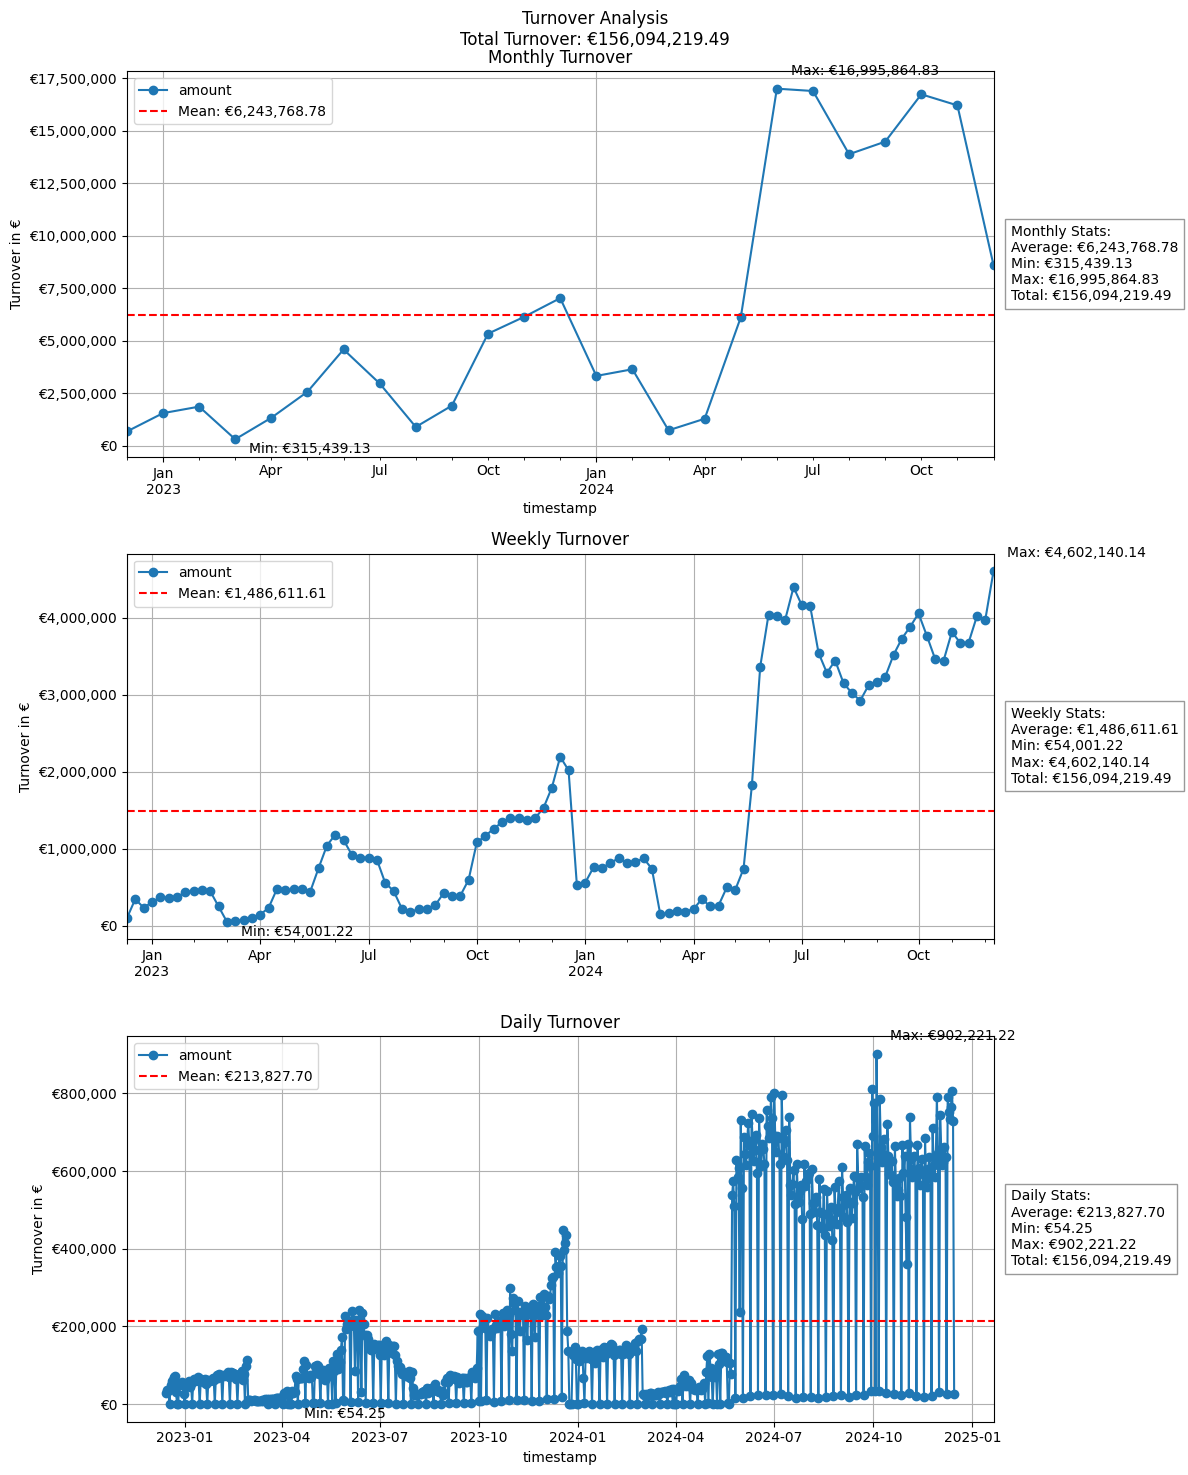

In [23]:
def analyze_turnover(df):
    total_turnover = df['amount'].sum()
    
    analyses = {
        'Monthly': df.groupby(df['timestamp'].dt.to_period('M'))['amount'].sum(),
        'Weekly': df.groupby([df['timestamp'].dt.isocalendar().year, 
                            df['timestamp'].dt.isocalendar().week])['amount'].sum(),
        'Daily': df.groupby(df['timestamp'].dt.date)['amount'].sum()
    }
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    fig.suptitle(f'Turnover Analysis\nTotal Turnover: €{total_turnover:,.2f}')
    
    for idx, (period, data) in enumerate(analyses.items()):
        ax = axes[idx]
        
        if period == 'Weekly':
            # Convert year-week to datetime
            dates = []
            for year, week in data.index:
                # Create a date object for the first day of the year
                first_day = pd.Timestamp(f"{year}-01-01")
                # Find the first Monday of the year
                monday = first_day + pd.Timedelta(days=(7 - first_day.weekday()) % 7)
                # Add the weeks
                dates.append(monday + pd.Timedelta(weeks=week-1))
            data.index = dates
            
        data.plot(ax=ax, marker='o')
        ax.set_title(f'{period} Turnover')
        ax.set_ylabel('Turnover in €')
        
        # Add mean line
        mean_val = data.mean()
        ax.axhline(y=mean_val, color='red', linestyle='--', 
                  label=f'Mean: €{mean_val:,.2f}')
        
        # Add max/min annotations
        max_val = data.max()
        min_val = data.min()
        ax.annotate(f'Max: €{max_val:,.2f}', 
                   xy=(data.idxmax(), max_val),
                   xytext=(10, 10), 
                   textcoords='offset points')
        ax.annotate(f'Min: €{min_val:,.2f}',
                   xy=(data.idxmin(), min_val),
                   xytext=(10, -10),
                   textcoords='offset points')
        
        # Add comprehensive stats box
        stats_text = (
            f'{period} Stats:\n'
            f'Average: €{mean_val:,.2f}\n'
            f'Min: €{min_val:,.2f}\n'
            f'Max: €{max_val:,.2f}\n'
            f'Total: €{data.sum():,.2f}'
        )
        ax.text(1.02, 0.5, stats_text, 
                transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                verticalalignment='center')
        
        ax.legend(loc='upper left')
        ax.grid(True)
        
        # Format y-axis with Euro symbol and thousands separator
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))
    
    plt.tight_layout()
    return analyses

# Run the analysis
turnover_analyses = analyze_turnover(full_df)

#### turnover per day of week

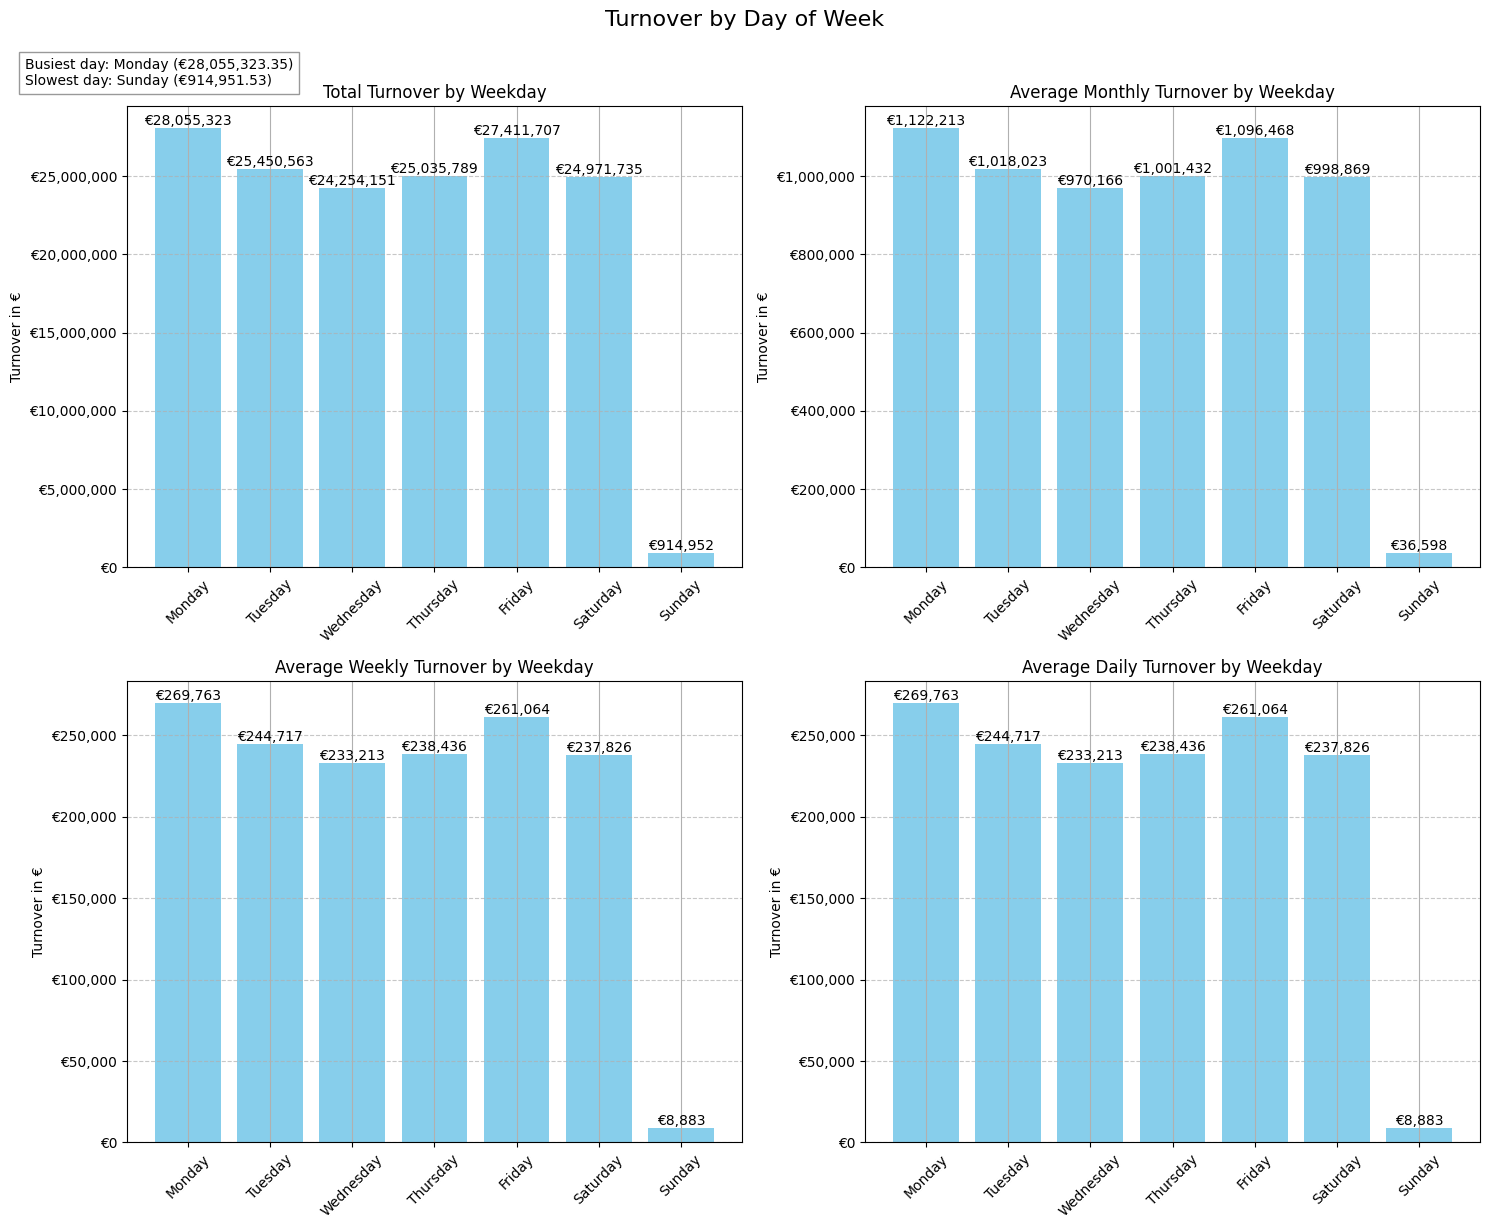

In [24]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Helper function for consistent formatting
def format_bars(ax, data, title):
    bars = ax.bar(weekday_order, data, color='skyblue')
    ax.set_title(title)
    ax.set_ylabel('Turnover in €')
    ax.tick_params(axis='x', rotation=45)

    # Format y-axis with Euro symbol and thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'€{height:,.0f}',
                ha='center', va='bottom', rotation=0)

    # Add grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    return bars


# Helper function to ensure all weekdays are present
def ensure_all_weekdays(series):
    missing_days = set(weekday_order) - set(series.index)
    for day in missing_days:
        series[day] = 0
    return series.reindex(weekday_order).fillna(0)


def analyze_weekday_turnover(df):
    """
    Analyzes pharmacy turnover by weekday, treating non-existent days as zero turnover.
    """
    df['weekday'] = df['timestamp'].dt.day_name()

    # Calculate aggregations with proper reindexing
    analyses = {
        'Total': ensure_all_weekdays(df.groupby('weekday')['amount'].sum()),
        'Monthly': df.groupby([df['timestamp'].dt.to_period('M'), 'weekday'])['amount'].sum(),
        'Weekly': df.groupby([df['timestamp'].dt.isocalendar().year, 
                            df['timestamp'].dt.isocalendar().week, 'weekday'])['amount'].sum(),
        'Daily': df.groupby([df['timestamp'].dt.date, 'weekday'])['amount'].sum()
    }

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Turnover by Day of Week', fontsize=16, y=1.02)

    # Total turnover by weekday
    format_bars(axes[0,0], analyses['Total'], 'Total Turnover by Weekday')

    # Monthly average
    monthly_means = []
    for day in weekday_order:
        # Get data for this weekday and handle missing values
        day_data = analyses['Monthly'].xs(day, level='weekday').fillna(0)
        monthly_means.append(day_data.mean())
    format_bars(axes[0,1], monthly_means, 'Average Monthly Turnover by Weekday')

    # Weekly average
    weekly_means = []
    for day in weekday_order:
        day_data = analyses['Weekly'].xs(day, level='weekday').fillna(0)
        weekly_means.append(day_data.mean())
    format_bars(axes[1,0], weekly_means, 'Average Weekly Turnover by Weekday')

    # Daily average
    daily_means = []
    for day in weekday_order:
        day_data = analyses['Daily'].xs(day, level='weekday').fillna(0)
        daily_means.append(day_data.mean())
    format_bars(axes[1,1], daily_means, 'Average Daily Turnover by Weekday')

    # Add some stats text in the figure
    plt.figtext(0.02, 0.98, 
                f'Busiest day: {analyses["Total"].idxmax()} (€{analyses["Total"].max():,.2f})\n'
                f'Slowest day: {analyses["Total"].idxmin()} (€{analyses["Total"].min():,.2f})',
                fontsize=10, ha='left', va='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    plt.tight_layout()
    return analyses

# Run the analysis
weekday_turnover_analyses = analyze_weekday_turnover(full_df)

### turnover by season

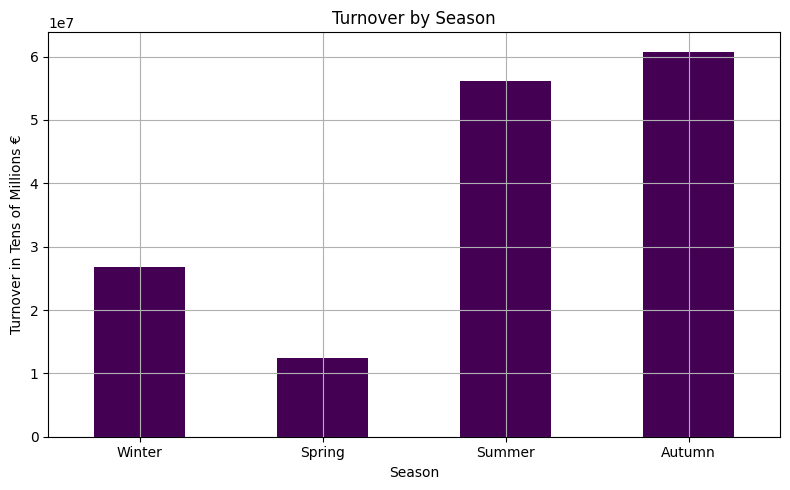

In [25]:
def get_season(date):
    """
    Determines the season based on the month of the given date.
    """
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'


def analyze_turnover_by_season(df):
    """
    Analyzes pharmacy turnover by season.
    """
    # Assign seasons based on timestamp
    df['season'] = df['timestamp'].apply(get_season)

    # Aggregate turnover by season
    season_turnover = df.groupby('season')['amount'].sum().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 5))
    season_turnover.plot(kind='bar', ax=ax, colormap='viridis', legend=False)
    ax.set_title('Turnover by Season')
    ax.set_ylabel('Turnover in Tens of Millions €')
    ax.set_xlabel('Season')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return season_turnover

# Run the analysis
season_turnover_analysis = analyze_turnover_by_season(full_df)



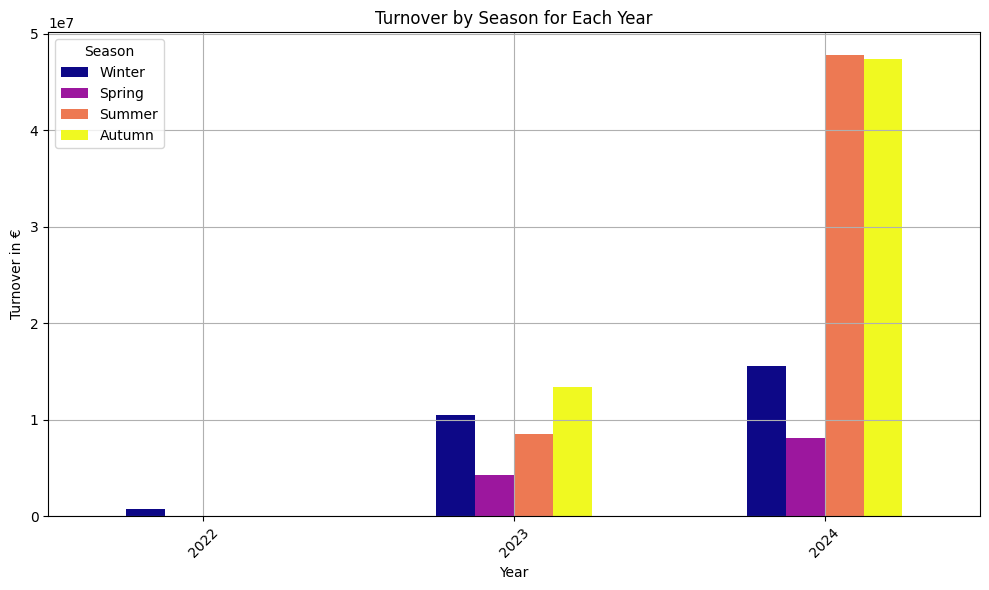

In [26]:
def analyze_turnover_by_season_and_year(df):
    """
    Analyzes pharmacy turnover by season for each year.
    """
    # Assign seasons based on timestamp
    df['season'] = df['timestamp'].apply(get_season)
    df['year'] = df['timestamp'].dt.year

    # Aggregate turnover by season and year
    season_year_turnover = (
        df.groupby(['year', 'season'])['amount']
        .sum()
        .unstack(level='season', fill_value=0)
        .reindex(columns=['Winter', 'Spring', 'Summer', 'Autumn'], fill_value=0)
    )

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    season_year_turnover.plot(kind='bar', ax=ax, colormap='plasma')
    ax.set_title('Turnover by Season for Each Year')
    ax.set_ylabel('Turnover in €')
    ax.set_xlabel('Year')
    ax.legend(title='Season')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return season_year_turnover

# Run the analysis
season_year_turnover_analysis = analyze_turnover_by_season_and_year(full_df)


####  number of pharmacies zipcode (grouped by the first digit only (large regions) or 2 digits (smaller regions)

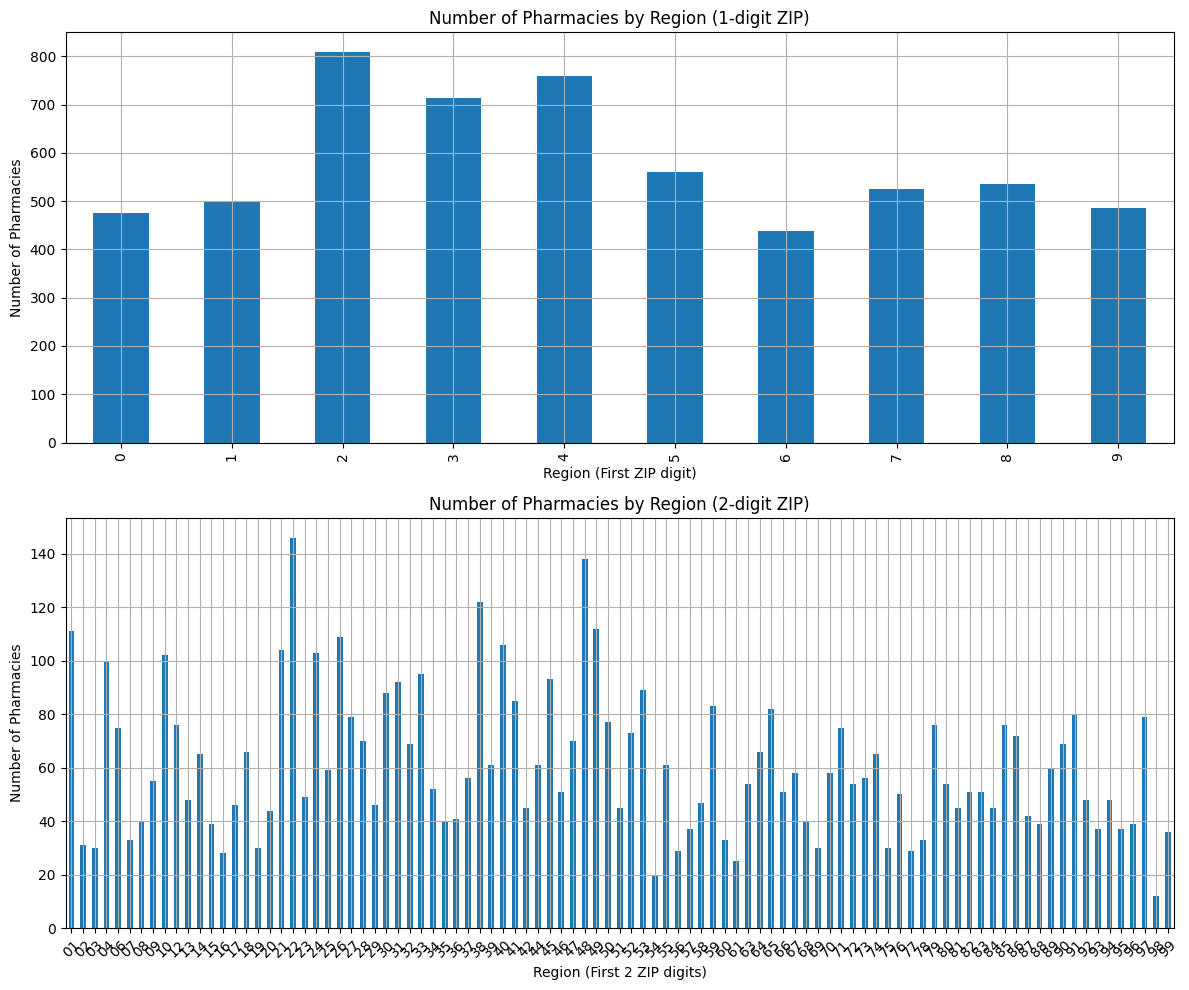

In [27]:
def analyze_pharmacy_distribution(df):
    """
    Analyzes pharmacy distribution across regions using first 1-2 digits of zip code.
    """
    # Create region columns
    df['region_1d'] = df['zipcode_area'].str[0]
    df['region_2d'] = df['zipcode_area'].str[:2]
    
    # Count unique pharmacies per region
    pharmacies_1d = df.groupby('region_1d')['gln'].nunique().sort_index()
    pharmacies_2d = df.groupby('region_2d')['gln'].nunique().sort_index()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Large regions (1-digit)
    pharmacies_1d.plot(kind='bar', ax=ax1)
    ax1.set_title('Number of Pharmacies by Region (1-digit ZIP)')
    ax1.set_xlabel('Region (First ZIP digit)')
    ax1.set_ylabel('Number of Pharmacies')
    
    # Smaller regions (2-digit)
    pharmacies_2d.plot(kind='bar', ax=ax2)
    ax2.set_title('Number of Pharmacies by Region (2-digit ZIP)')
    ax2.set_xlabel('Region (First 2 ZIP digits)')
    ax2.set_ylabel('Number of Pharmacies')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return {'large_regions': pharmacies_1d, 'small_regions': pharmacies_2d}

# Run the analysis
pharmacy_distribution = analyze_pharmacy_distribution(full_df)


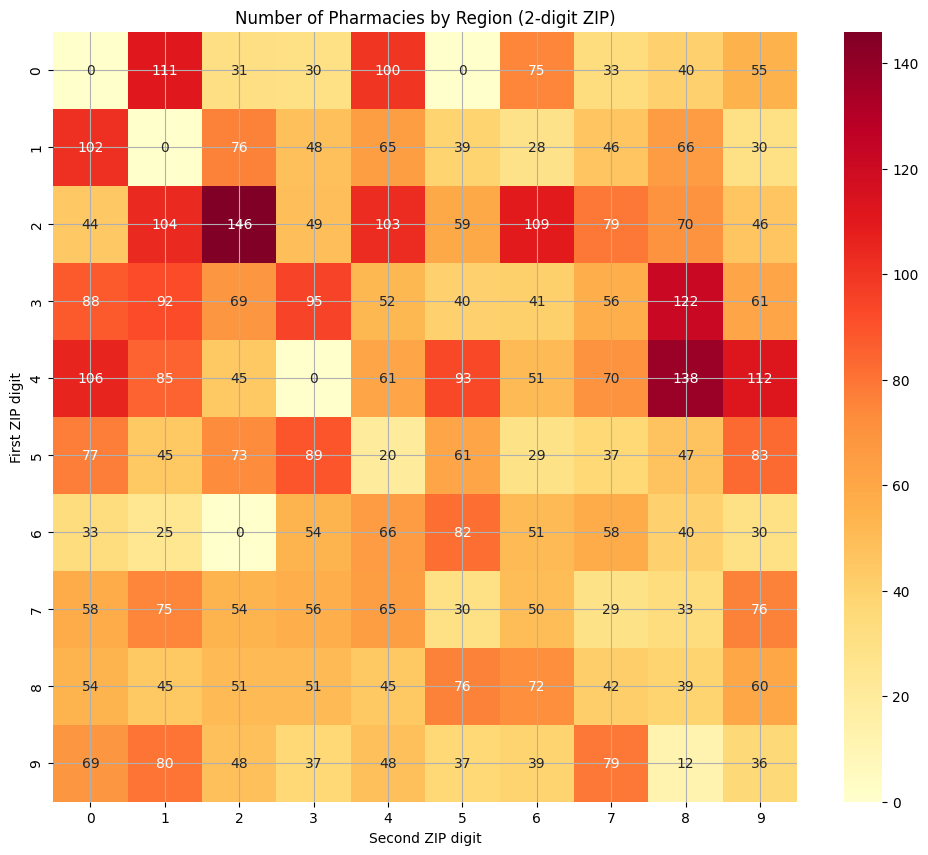

In [28]:
def analyze_pharmacy_distribution(df):
    """
    Creates a heatmap visualization of pharmacy distribution using 2-digit zip codes.
    Maps the first two digits to a 10x10 grid representing German postal regions.
    """
    df['region_2d'] = df['zipcode_area'].str[:2].astype(int)
    pharmacies_2d = df.groupby('region_2d')['gln'].nunique()
    
    # Create 10x10 grid for visualization
    grid = np.zeros((10, 10))
    for zip_code, count in pharmacies_2d.items():
        row = zip_code // 10
        col = zip_code % 10
        grid[row, col] = count
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(grid, annot=True, fmt='.0f', cmap='YlOrRd')
    plt.title('Number of Pharmacies by Region (2-digit ZIP)')
    plt.xlabel('Second ZIP digit')
    plt.ylabel('First ZIP digit')
    
    return pharmacies_2d

# Run the analysis
pharmacy_distribution = analyze_pharmacy_distribution(full_df)

#### Regional Sales Patterns

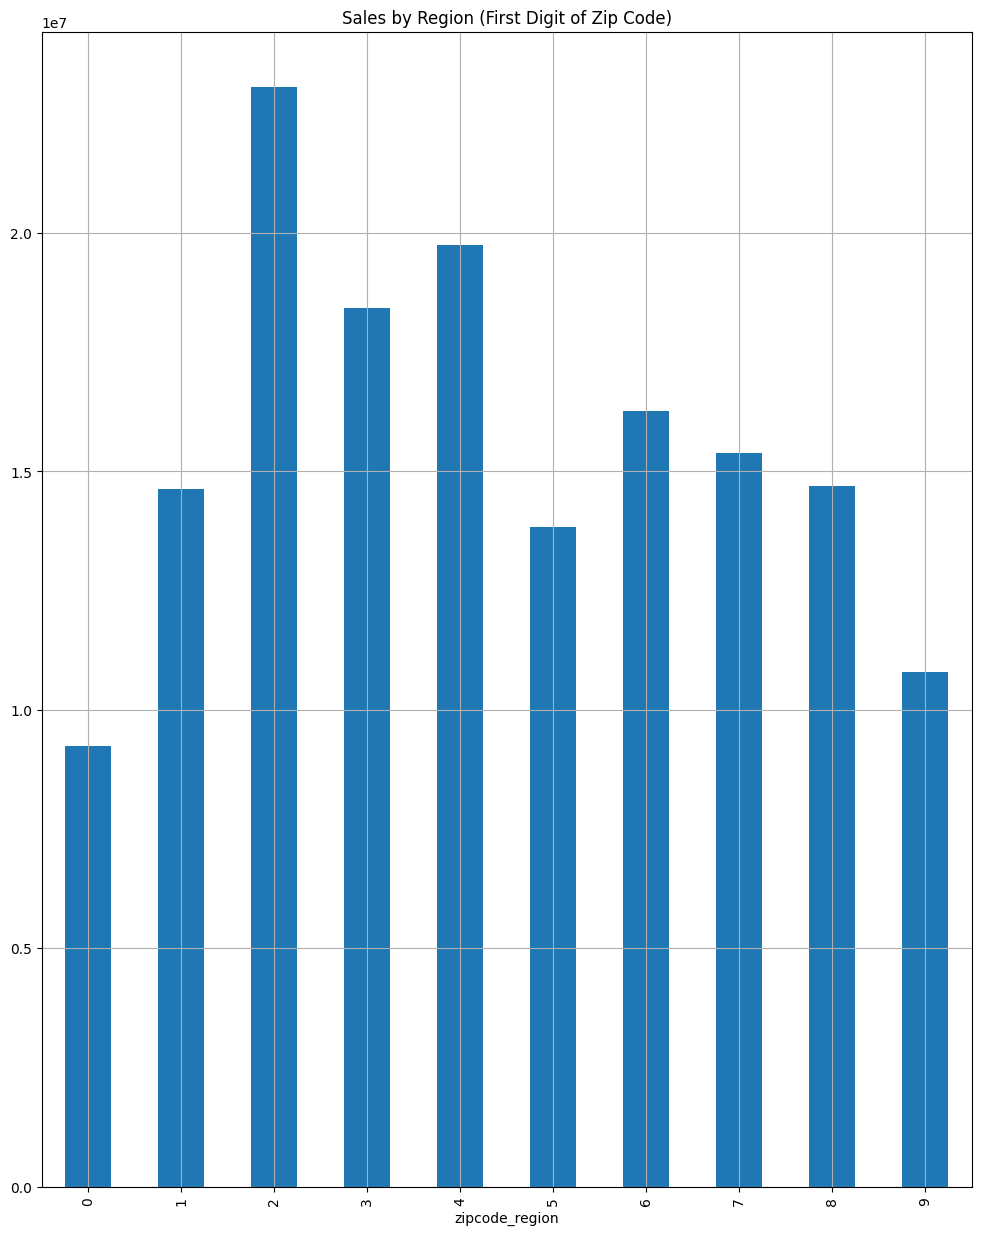

In [29]:
# By First Digit of Zip Code
full_df['zipcode_region'] = full_df['zipcode_area'].str[0]
regional_sales = full_df.groupby('zipcode_region')['amount'].sum()
regional_sales.plot(kind='bar', title='Sales by Region (First Digit of Zip Code)')
plt.show()

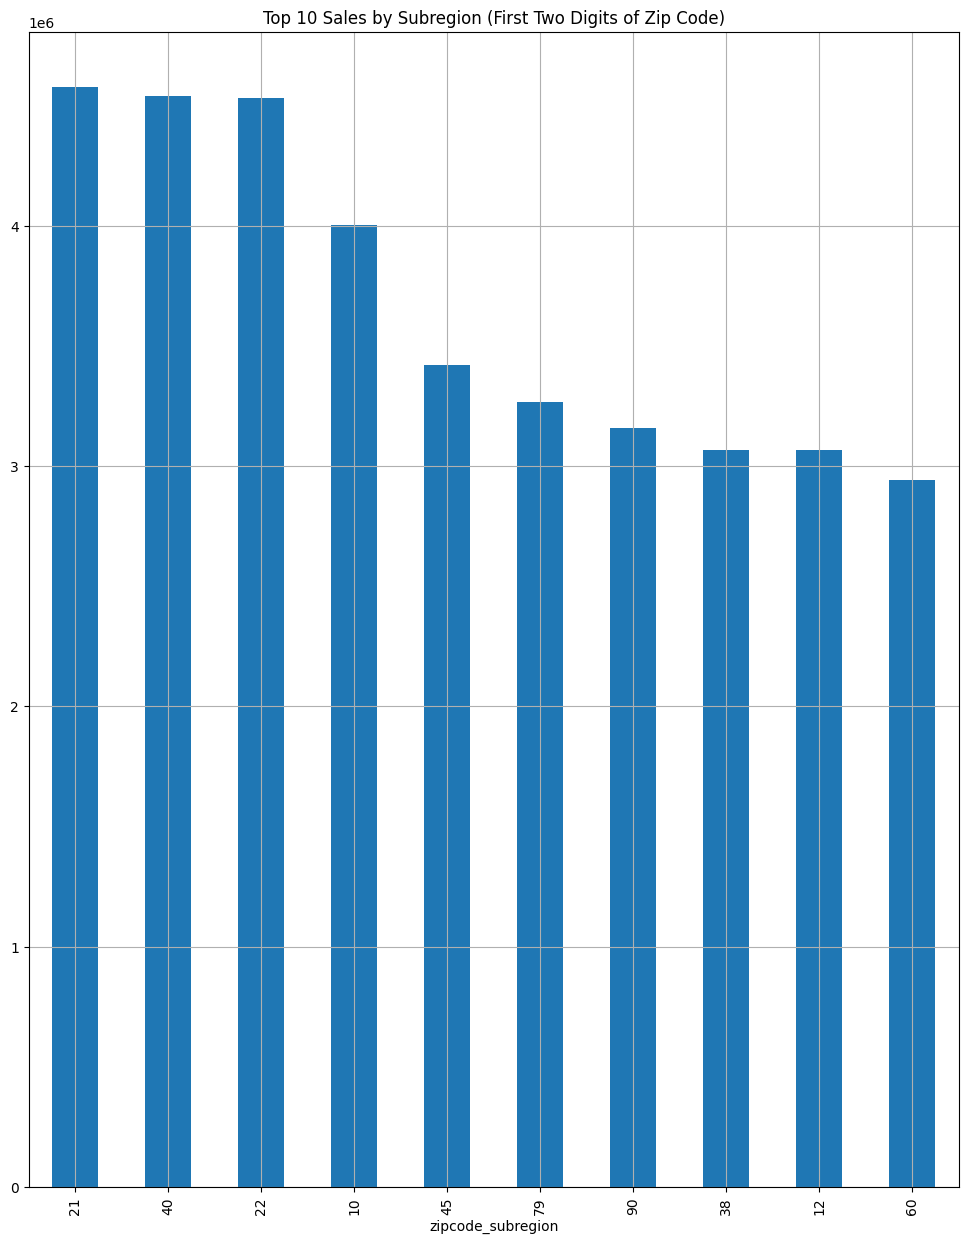

In [30]:
# By First Two Digits of Zip Code
full_df['zipcode_subregion'] = full_df['zipcode_area'].str[:2]
subregional_sales = full_df.groupby('zipcode_subregion')['amount'].sum()

# Get the top 10 subregions by sales
top_10_subregional_sales = subregional_sales.nlargest(10)

top_10_subregional_sales.plot(kind='bar', title='Top 10 Sales by Subregion (First Two Digits of Zip Code)')
plt.show()

----------------

## Part 3: confirm the content of the customer report

- the promotional campaign run by Beiersdorf for the product line "Eucerin" from  1/12/2023, to 29/2/2024

In [31]:
# 1. get only the line in the date range of the campaign (1/12/2023, to 29/2/2024)
campaign_start = datetime(2023, 12, 1)
campaign_end = datetime(2024, 2, 29)
campaign_df = full_df[(full_df['timestamp'] >= campaign_start) & (full_df['timestamp'] <= campaign_end)]

print(f"totla count", len(full_df))
print(f"campaign count", len(campaign_df))
print(f"campaign percentage", len(campaign_df) / len(full_df))



totla count 12056199
campaign count 872194
campaign percentage 0.07234402816343692


In [32]:
# 2. get only products that are from the brand "Eucerin"
eucerin_campaign_df = campaign_df[campaign_df['name'].str.contains('Eucerin', case=False, na=False)]
print(f"Number of Eucerin products: {len(eucerin_campaign_df)}")
print(f"Percentage of Eucerin products: {len(eucerin_campaign_df) / len(campaign_df)}")

Number of Eucerin products: 291246
Percentage of Eucerin products: 0.33392341612072546


In [33]:
# 3. get non-Eucerin products
non_promotional_items_df = campaign_df[~campaign_df['name'].str.contains('Eucerin', case=False, na=False)]

---------

#### Page 1 

In [34]:
# average number of total items per receipt (take quantity into account)
# for every receipt, calculate the total number of items (sum of quantity)
# then calculate the average of these numbers

average_items_per_receipt = campaign_df.groupby('transaction_id')['quantity'].sum().mean()
print(f"average number of articles per receipt (report value = 2.09): {average_items_per_receipt}")


average_items_per_receipt = eucerin_campaign_df.groupby('transaction_id')['quantity'].sum().mean()
print(f"average number of promotional items per receipt (report value = 1.31): {average_items_per_receipt}")

average number of articles per receipt (report value = 2.09): 2.067445736375153
average number of promotional items per receipt (report value = 1.31): 1.302671213172457


In [35]:
# average turnover per receipt
reciepts_with_one_or_more_promotional_items = eucerin_campaign_df['transaction_id'].unique()
reciepts_to_consider = campaign_df[campaign_df['transaction_id'].isin(reciepts_with_one_or_more_promotional_items)]
average_turnover_per_receipt = reciepts_to_consider.groupby('transaction_id')['amount'].sum().mean()
print(f"average total turnover per receipt with one or more coupons (report value = 39.31): {average_turnover_per_receipt}")

average_turnover_per_receipt = eucerin_campaign_df.groupby('transaction_id')['amount'].sum().mean()
print(f"average turnover of promotional items per receipt with one or more coupons (report value = 31.13): {average_turnover_per_receipt}")


average total turnover per receipt with one or more coupons (report value = 39.31): 39.123318159511285
average turnover of promotional items per receipt with one or more coupons (report value = 31.13): 30.846236398558204


In [36]:
# number of pharmacies
print(f"Number of pharmacies in the Eucerin ca  mpaign (report: 3.485): {eucerin_campaign_df['gln'].nunique()}")

# number of Eucerin products sold
print(f"Number of Eucerin products sold in the Eucerin campaign (report: 407.827): {eucerin_campaign_df["quantity"].sum()}")


Number of pharmacies in the Eucerin campaign (report: 3.485): 3546
Number of Eucerin products sold in the Eucerin campaign (report: 407.827): 307915


--------------

### Page 2

In [37]:
#  the number of items per receipt (x-axis) and the average price of all promotional items on that receipt (y-axis) (1, 2, 3, 4, 5, 6, 7, 8, 9, >=10)
def calculate_average_price_for_items(n, operation="="):
        # get the transaction_id for receipts with n items
        if operation == "=":
            item_receipts = eucerin_campaign_df.groupby('transaction_id').filter(lambda x: len(x) == n)['transaction_id']
        elif operation == ">=":
            item_receipts = eucerin_campaign_df.groupby('transaction_id').filter(lambda x: len(x) >= n)['transaction_id']
        print(f"Number of receipts with {n} items: {len(item_receipts)}")
        # calculate the total for each receipt
        item_receipts = eucerin_campaign_df[eucerin_campaign_df['transaction_id'].isin(item_receipts)]
        # calculate the total amount for each receipt
        item_receipts = item_receipts.groupby('transaction_id')['amount'].sum()
        # calculate the average
        average_item_receipts = item_receipts.mean()
        print(f"Average price for receipts with {n} items or more: {average_item_receipts}")
        return average_item_receipts


data_points = [1, 2, 3, 4, 5, 6, 7, 8, 9]
average_prices = []
for i in data_points:
    average_prices.append(calculate_average_price_for_items(i))

# get the average price for receipts with 10 or more items
average_prices.append(calculate_average_price_for_items(10, ">="))


Number of receipts with 1 items: 188936
Average price for receipts with 1 items or more: 27.814291294406573
Number of receipts with 2 items: 83218
Average price for receipts with 2 items or more: 38.92077026604821
Number of receipts with 3 items: 13980
Average price for receipts with 3 items or more: 63.61230042918455
Number of receipts with 4 items: 3548
Average price for receipts with 4 items or more: 91.76364148816234
Number of receipts with 5 items: 915
Average price for receipts with 5 items or more: 118.18683060109286
Number of receipts with 6 items: 384
Average price for receipts with 6 items or more: 155.08203125
Number of receipts with 7 items: 98
Average price for receipts with 7 items or more: 202.6014285714286
Number of receipts with 8 items: 112
Average price for receipts with 8 items or more: 221.61499999999998
Number of receipts with 9 items: 9
Average price for receipts with 9 items or more: 236.15
Number of receipts with 10 items: 46
Average price for receipts with 10 

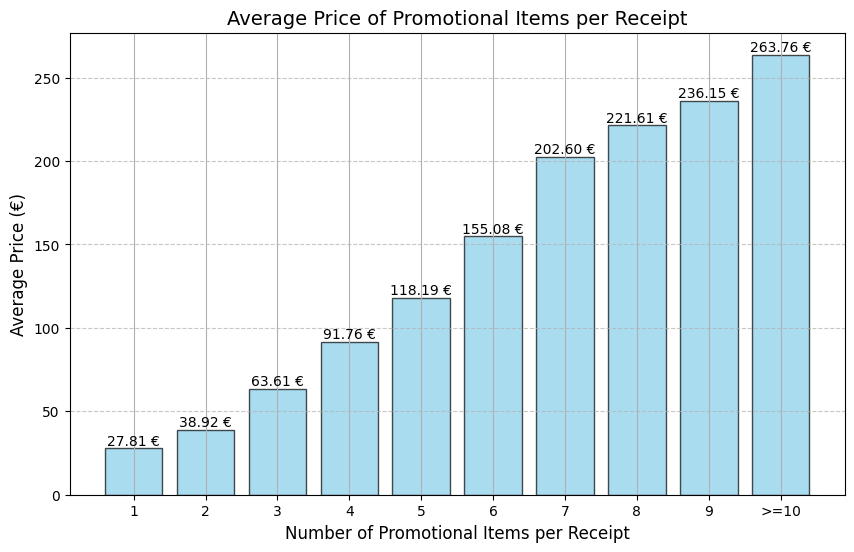

In [38]:
labels = [f'{i}' for i in data_points] + ['>=10']
values = average_prices

# Adding exact values to the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color='skyblue', alpha=0.7, edgecolor='black')
plt.xlabel('Number of Promotional Items per Receipt', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)
plt.title('Average Price of Promotional Items per Receipt', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the exact values on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f} €',
             ha='center', va='bottom', fontsize=10)

plt.show()


------------

### Page 3
we only care about items that has at least one promotional items on them
- talbe 1 is about both promotional and none
- table 2 is about promotional items and we are getting almost the same results
- table 3 is about non-promotional items for Receipts in the campine

In [39]:
only_eucerin = campaign_df[campaign_df['transaction_id'].isin(eucerin_campaign_df['transaction_id'])]
print("total number of receipts", len(only_eucerin['transaction_id'].unique()))

# tabl 1 (all items)
def filter_receipts_by_items(n, operation="="):
    if operation == "=":
        filtered_receipts = only_eucerin.groupby('transaction_id').filter(lambda x: len(x) == n)['transaction_id']
    elif operation == ">=":
        filtered_receipts = only_eucerin.groupby('transaction_id').filter(lambda x: len(x) >= n)['transaction_id']
    print(f"Receipts with {operation} {n} promotional items: {len(set(filtered_receipts))}")
    # return filtered_receipts

# Filter receipts for 1 to 9 and >= 10 promotional items
for i in range(1, 10):
    filter_receipts_by_items(i)

filter_receipts_by_items(10, ">=")

total number of receipts 236372
Receipts with = 1 promotional items: 126004
Receipts with = 2 promotional items: 63793
Receipts with = 3 promotional items: 26253
Receipts with = 4 promotional items: 10959
Receipts with = 5 promotional items: 4747
Receipts with = 6 promotional items: 2226
Receipts with = 7 promotional items: 1037
Receipts with = 8 promotional items: 579
Receipts with = 9 promotional items: 303
Receipts with >= 10 promotional items: 471


In [40]:
## Table 2 (promotional items)
# Define a function to filter receipts based on the number of promotional items
def filter_receipts_by_items(n, operation="="):
    if operation == "=":
        filtered_receipts = eucerin_campaign_df.groupby('transaction_id').filter(lambda x: len(x) == n)['transaction_id']
    elif operation == ">=":
        filtered_receipts = eucerin_campaign_df.groupby('transaction_id').filter(lambda x: len(x) >= n)['transaction_id']
    print(f"Receipts with {operation} {n} promotional items: {len(set(filtered_receipts))}")
    # return filtered_receipts

# Filter receipts for 1 to 9 and >= 10 promotional items
for i in range(1, 10):
    filter_receipts_by_items(i)

filter_receipts_by_items(10, ">=")


Receipts with = 1 promotional items: 188936
Receipts with = 2 promotional items: 41609
Receipts with = 3 promotional items: 4660
Receipts with = 4 promotional items: 887
Receipts with = 5 promotional items: 183
Receipts with = 6 promotional items: 64
Receipts with = 7 promotional items: 14
Receipts with = 8 promotional items: 14
Receipts with = 9 promotional items: 1
Receipts with >= 10 promotional items: 4


In [41]:
## Table 3 (non-promotional items)
# Define a function to filter receipts based on the number of non-promotional items

# want the reciepts that have promotional items only
reciepts_only_in_campaign = campaign_df[campaign_df['transaction_id'].isin(eucerin_campaign_df['transaction_id'])]
reciepts_only_in_campaign = reciepts_only_in_campaign[~reciepts_only_in_campaign['name'].str.contains('Eucerin', case=False, na=False)]

# 0 non-promotional items
number_of_receipts_with_zero_non_promotional_items = eucerin_campaign_df[~eucerin_campaign_df['transaction_id'].isin(reciepts_only_in_campaign['transaction_id'])]['transaction_id'].nunique()
print(f"Number of receipts with 0 non-promotional items: {number_of_receipts_with_zero_non_promotional_items}")

def filter_receipts_by_items(n, operation="="):
    if operation == "=":
        filtered_receipts = reciepts_only_in_campaign.groupby('transaction_id').filter(lambda x: len(x) == n)['transaction_id']
    elif operation == ">=":
        filtered_receipts = reciepts_only_in_campaign.groupby('transaction_id').filter(lambda x: len(x) >= n)['transaction_id']
    print(f"Receipts with {operation} {n} non-promotional items: {len(set(filtered_receipts))}")
    # return filtered_receipts

# Filter receipts for 1 to 9 and >= 10 promotional items
for i in range(1, 10):
    filter_receipts_by_items(i)

filter_receipts_by_items(10, ">=")


Number of receipts with 0 non-promotional items: 155179
Receipts with = 1 non-promotional items: 48030
Receipts with = 2 non-promotional items: 19032
Receipts with = 3 non-promotional items: 7689
Receipts with = 4 non-promotional items: 3255
Receipts with = 5 non-promotional items: 1474
Receipts with = 6 non-promotional items: 773
Receipts with = 7 non-promotional items: 389
Receipts with = 8 non-promotional items: 237
Receipts with = 9 non-promotional items: 127
Receipts with >= 10 non-promotional items: 187


------

### Page 4

In [42]:
# Top 20 products by revenue
products = eucerin_campaign_df.groupby('pzn')['amount'].sum().sort_values(ascending=False).head(20)

#  get the average price for the top 20 products
# calc: total amount / total quantity
rseults = []
for pzn in products.index:
    product = {"pzn": pzn, "name": products_df[products_df['pzn'] == pzn]['name'].values[0]}
    total_amount = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['amount'].sum()
    total_quantity = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['quantity'].sum()
    average_price = total_amount / total_quantity
    product['average_price'] = average_price

    #  number of items sold
    product['number_of_items_sold'] = total_quantity

    # number of receipts
    product['number_of_receipts'] = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['transaction_id'].nunique()

    rseults.append(product)

# write the top 20 products to a csv file
rseults = pd.DataFrame(rseults)
# number should only 2 decimal points
rseults['average_price'] = rseults['average_price'].round(2)
rseults.to_csv('top_20_products.csv', index=False)

# validation

pzn_from_report = ['11678159','11652964','04668723','16154610','08454746','08454700','11652958','18222089','13929074','07608420','15581586','15294332','14163898','11678142','13167925','11678001','14163929','12441459','11678047','11678099']

# get the overlap between the top 20 products from the report and the top 20 products from the analysis
overlap = rseults[rseults['pzn'].isin(pzn_from_report)]["pzn"].tolist()
print("overlap between the top 20 products from the report and the top 20 products from the analysis", overlap)

# in the report but not in the analysis
not_in_analysis = [pzn for pzn in pzn_from_report if pzn not in rseults['pzn'].tolist()]
print("in the report but not in the analysis", not_in_analysis)

# in the analysis but not in the report
not_in_report = rseults[~rseults['pzn'].isin(pzn_from_report)]["pzn"].tolist()
print("in the analysis but not in the report", not_in_report)

overlap between the top 20 products from the report and the top 20 products from the analysis ['11652964', '11678159', '16154610', '04668723', '18222089', '11652958', '13929074', '07608420', '08454746', '08454700', '14163929', '14163898', '15581586', '13167925', '15294332', '11678001', '11678142']
in the report but not in the analysis ['12441459', '11678047', '11678099']
in the analysis but not in the report ['01552397', '15257408', '01171175']


#### insight: 
- first 17 in our analysis is the same, the last 3 are different. the number 20 is the report is number 37 in our code

- for the 17 that match, the number of items sold, number of receipts and the average prices are <mark>close enough</mark>


## Page 5:

Top 20 Promotional Items and the quantities sold 
Insights:
We have similar numbers in quantity and the average price and the top but get a lot of rows with zeros in them, due to the lack of data.

In [43]:
# Load the top 20 products CSV
top_20_products = pd.read_csv("top_20_products.csv")

# Ensure the "pzn" column is of string type and strip leading/trailing spaces
top_20_products["pzn"] = top_20_products["pzn"].astype(str).str.strip()
lineitems_df["pzn"] = lineitems_df["pzn"].astype(str).str.strip()

# Filter receipts_df for the specified date range
receipts_df["timestamp"] = pd.to_datetime(receipts_df["timestamp"])
filtered_receipts = receipts_df[
    (receipts_df["timestamp"] >= "2023-12-01") & (receipts_df["timestamp"] <= "2024-02-29")
]

# Merge filtered receipts with lineitems_df to keep only transactions in the specified date range
filtered_lineitems = lineitems_df[lineitems_df["transaction_id"].isin(filtered_receipts["transaction_id"])]

# Filter lineitems_df to include only the products in top_20_products
top_20_pzn = top_20_products["pzn"].tolist()
filtered_data = filtered_lineitems[filtered_lineitems["pzn"].isin(top_20_pzn)]

# Merge with products_df to include product names
filtered_data = filtered_data.merge(products_df, on="pzn", how="left")

# Group by transaction_id and pzn to calculate quantities per receipt
grouped_data = (
    filtered_data.groupby(["transaction_id", "pzn", "name"], as_index=False)
    .agg(quantity=("quantity", "sum"), total_amount=("amount", "sum"))
)

# Calculate average price for each receipt
grouped_data["average_price"] = grouped_data["total_amount"] / grouped_data["quantity"]

# Initialize quantities of interest
quantities_of_interest = [1, 2, 3, 4, 5, 6, 8, 10]

# Prepare the result table
result_table = []

for pzn, product_name in top_20_products[["pzn", "name"]].values:
    product_data = grouped_data[grouped_data["pzn"] == pzn]
    row = {"pzn": pzn, "product_name": product_name}
    total_sold = 0
    total_amount = 0

    for quantity in quantities_of_interest:
        qty_data = product_data[product_data["quantity"] == quantity]
        qty_count = qty_data.shape[0]  # Number of receipts matching this quantity
        avg_price = qty_data["average_price"].mean() if qty_count > 0 else 0
        row[f"quantity_{quantity}"] = qty_count
        row[f"avg_price_{quantity}"] = avg_price
        total_sold += qty_count * quantity
        total_amount += qty_count * avg_price

    row["total_sold"] = total_sold
    row["total_avg_price"] = total_amount / total_sold if total_sold > 0 else 0
    result_table.append(row)

# Convert the result to a DataFrame
result_df = pd.DataFrame(result_table)

# Sort the table by "total_sold" in descending order
result_df = result_df.sort_values(by="total_sold", ascending=False)

# Save the resulting table to a CSV file
output_path = "quantities_table_for_top_20_products_time_filtered_sorted.csv"
result_df.to_csv(output_path, index=False)

print(f"Result saved to {output_path}")


Result saved to quantities_table_for_top_20_products_time_filtered_sorted.csv


# Page 6: Top 20 Promotion Items + Top Non-promotion Item at a glance
#### Almost 50% data matches, with the given dataset. 
#### For rest: 2nd highest sold product is in report.

In [44]:
# Step 1: Create promotion and non-promotion dataframes
nonpromotiondf = non_promotional_items_df

promotiondf_sorted =  eucerin_campaign_df.groupby('pzn')['amount'].sum().sort_values(ascending=False).head(20)
promotiondf_sorted = promotiondf_sorted.reset_index()

results = []

# Step 4: Loop through top promotion products
for _, promo_row in promotiondf_sorted.iterrows():
    promo_transaction_ids_set = set(eucerin_campaign_df[eucerin_campaign_df['pzn'] == promo_row['pzn']]['transaction_id'])
    
    # Step 6: Filter non-promotion products purchased in the same transactions
    nonpromo_in_same_transactions = nonpromotiondf[nonpromotiondf['transaction_id'].isin(promo_transaction_ids_set)]
    
    # Step 7: Sort by quantity and select top 3 non-promotion products
    top_nonpromo_products = nonpromo_in_same_transactions.groupby('pzn').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False).head(1)
    # Step 8: Create the result for this promotion product
    # top_nonpromo_products = nonpromo_in_same_transactions.groupby('pzn').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False).head(3)
    # Step 7: Create the result for this promotion product
    for nonpromo_product, nonpromo_quantity in top_nonpromo_products.itertuples():
        combined_details = {
            'Promotion Product': promo_row['pzn'],
            'Promotion Amount': promo_row['amount'],
            'Non-Promotion Product': nonpromo_product,
            'Non-Promotion Quantity': nonpromo_quantity
        }
        results.append(combined_details)

# Convert the results into a DataFrame
result_df = pd.DataFrame(results)
print("result section")
dataFromReport = [
    {"Promotion Product": "11678159", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "11652964", "Non-Promotion Product": "01578818"},
    {"Promotion Product": "04668723", "Non-Promotion Product": "13155684"},
    {"Promotion Product": "16154610", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "08454746", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "08454700", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "11652958", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "18222089", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "13929074", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "07608420", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "15581586", "Non-Promotion Product": "01578818"},
    {"Promotion Product": "15294332", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "14163898", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "13167925", "Non-Promotion Product": "00999831"},
    {"Promotion Product": "11678001", "Non-Promotion Product": "01578818"},
    {"Promotion Product": "14163929", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "12441459", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "11678047", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "11678099", "Non-Promotion Product": "01578675"}
]

# Create DataFrame
dataFromReport_DF = pd.DataFrame(dataFromReport)

# Merge DataFrames to find matching rows based on "Promotion Product" and "Non-Promotion Product"
matching_rows = pd.merge(result_df, dataFromReport_DF, on=["Promotion Product", "Non-Promotion Product"], how="inner")

# Filter only the "Promotion Product" and "Non-Promotion Product" columns from the matching rows
matching_rows_filtered = matching_rows[["Promotion Product", "Non-Promotion Product"]]

# Print results for matching rows
matching_rows_count = matching_rows_filtered.shape[0]
print(f"\nNumber of matching rows: {matching_rows_count}\n")
print(matching_rows_filtered)

# Merge DataFrames to find both matching and non-matching rows
matching_rows_todelete = pd.merge(result_df, matching_rows_filtered, on=["Promotion Product", "Non-Promotion Product"], how="inner")

# Filter result_df to remove the matching rows based on both "Promotion Product" and "Non-Promotion Product"
df1_cleaned = result_df[~result_df.set_index(["Promotion Product", "Non-Promotion Product"]).index.isin(matching_rows_todelete.set_index(["Promotion Product", "Non-Promotion Product"]).index)]

# Print the number of matching rows and the final DataFrame
matching_rows_countToDelete = matching_rows_todelete.shape[0]
print(f"\nNumber of non matching rows: {matching_rows_countToDelete}\n")

# Print the cleaned DataFrame
print(df1_cleaned[["Promotion Product", "Non-Promotion Product"]])

result section

Number of matching rows: 11

   Promotion Product Non-Promotion Product
0           11678159              01580241
1           16154610              01126111
2           18222089              01578675
3           07608420              01126111
4           08454746              01580241
5           08454700              01580241
6           14163929              01126111
7           14163898              01126111
8           13167925              00999831
9           15294332              01580241
10          11678001              01578818

Number of non matching rows: 11

   Promotion Product Non-Promotion Product
0           11652964              01578675
3           04668723              01126111
5           11652958              01578675
6           13929074              12521543
12          15581586              12521543
16          01552397              01580241
17          15257408              01578675
18          11678142              01580241
19          011711

# Page 7: Top Promotion Items + Top 3 Non-promotion Items
#### Almost 95% data matches, with the given dataset. 
#### Only one non-promotion item is different from report data

In [45]:
# Step 1: Create promotion and non-promotion dataframes
nonpromotiondf = non_promotional_items_df

promotiondf_sorted =  eucerin_campaign_df.groupby('pzn')['amount'].sum().sort_values(ascending=False).head(20)
promotiondf_sorted = promotiondf_sorted.reset_index()

results = []

# Step 4: Loop through top promotion products
for _, promo_row in promotiondf_sorted.iterrows():
    promo_transaction_ids_set = set(eucerin_campaign_df[eucerin_campaign_df['pzn'] == promo_row['pzn']]['transaction_id'])
    
    # Step 6: Filter non-promotion products purchased in the same transactions
    nonpromo_in_same_transactions = nonpromotiondf[nonpromotiondf['transaction_id'].isin(promo_transaction_ids_set)]
    
    # Step 7: Sort by quantity and select top 3 non-promotion products
    top_nonpromo_products = nonpromo_in_same_transactions.groupby('pzn').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False).head(3)
    
    # Step 8: Create the result for this promotion product
    # top_nonpromo_products = nonpromo_in_same_transactions.groupby('pzn').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False).head(3)
    # Step 7: Create the result for this promotion product
    for nonpromo_product, nonpromo_quantity in top_nonpromo_products.itertuples():
        combined_details = {
            'Promotion Product': promo_row['pzn'],
            'Promotion Amount': promo_row['amount'],
            'Non-Promotion Product': nonpromo_product,
            'Non-Promotion Quantity': nonpromo_quantity
        }
        results.append(combined_details)

# Convert the results into a DataFrame
result_df = pd.DataFrame(results)
promotion_product_values = ['08454746','11678159', '11652964', '04668723', '16154610', ]
 
# Filter the result_df for these promotion products
filtered_result_df = result_df[result_df['Promotion Product'].isin(promotion_product_values)]
filtered_result_df_unique = filtered_result_df.drop_duplicates(subset=['Promotion Product', 'Non-Promotion Product'])

dataFromReport = [
    {"Promotion Product": "11678159", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "11678159", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "11678159", "Non-Promotion Product": "13155684"},
    {"Promotion Product": "11652964", "Non-Promotion Product": "01578818"},
    {"Promotion Product": "11652964", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "11652964", "Non-Promotion Product": "00495970"},
    {"Promotion Product": "04668723", "Non-Promotion Product": "13155684"},
    {"Promotion Product": "04668723", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "04668723", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "16154610", "Non-Promotion Product": "01126111"},
    {"Promotion Product": "16154610", "Non-Promotion Product": "13155684"},
    {"Promotion Product": "16154610", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "08454746", "Non-Promotion Product": "01580241"},
    {"Promotion Product": "08454746", "Non-Promotion Product": "01578675"},
    {"Promotion Product": "08454746", "Non-Promotion Product": "01578681"}
]

# Create DataFrame
dataFromReport_DF = pd.DataFrame(dataFromReport)


# Merge DataFrames to find matching rows based on "Promotion Product" and "Non-Promotion Product"
matching_rows = pd.merge(filtered_result_df_unique, dataFromReport_DF, on=["Promotion Product", "Non-Promotion Product"], how="inner")

# Filter only the "Promotion Product" and "Non-Promotion Product" columns from the matching rows
matching_rows_filtered = matching_rows[["Promotion Product", "Non-Promotion Product"]]

# Print results for matching rows
matching_rows_count = matching_rows_filtered.shape[0]
print(f"\nNumber of matching rows: {matching_rows_count}\n")
print(matching_rows_filtered)

# Merge DataFrames to find both matching and non-matching rows
matching_rows_todelete = pd.merge(filtered_result_df_unique, matching_rows_filtered, on=["Promotion Product", "Non-Promotion Product"], how="inner")

# Filter result_df to remove the matching rows based on both "Promotion Product" and "Non-Promotion Product"
df1_cleaned = filtered_result_df_unique[~filtered_result_df_unique.set_index(["Promotion Product", "Non-Promotion Product"]).index.isin(matching_rows_todelete.set_index(["Promotion Product", "Non-Promotion Product"]).index)]

# Print the number of matching rows and the final DataFrame
nonmatching_rows_count = df1_cleaned.shape[0]
print(f"\nNumber of non matching rows: {nonmatching_rows_count}\n")

# Print the cleaned DataFrame
print(df1_cleaned[["Promotion Product", "Non-Promotion Product"]])



Number of matching rows: 13

   Promotion Product Non-Promotion Product
0           11652964              01578675
1           11652964              01578818
2           11652964              00495970
3           11678159              01580241
4           11678159              01578675
5           11678159              13155684
6           16154610              01126111
7           16154610              13155684
8           16154610              01580241
9           04668723              01126111
10          04668723              13155684
11          08454746              01580241
12          08454746              01578675

Number of non matching rows: 2

   Promotion Product Non-Promotion Product
11          04668723              12521543
26          08454746              00999831


# Page 8:

Top Promotion item and most sold promotion item together with them

Insights: 
Three out of five are very close to the one of the report. 
For one promotion item there is nothing found and the other one is different to ours.

In [46]:
# Load the top 20 products CSV
top_20_products = pd.read_csv("top_20_products.csv")

# Ensure the "pzn" column is of string type and strip leading/trailing spaces
top_20_products["pzn"] = top_20_products["pzn"].astype(str).str.strip()
lineitems_df["pzn"] = lineitems_df["pzn"].astype(str).str.strip()

# Filter receipts_df for the specified date range
receipts_df["timestamp"] = pd.to_datetime(receipts_df["timestamp"])
filtered_receipts = receipts_df[
    (receipts_df["timestamp"] >= "2023-12-01") & (receipts_df["timestamp"] <= "2024-02-29")
]

# Merge filtered receipts with lineitems_df to keep only transactions in the specified date range
filtered_lineitems = lineitems_df[lineitems_df["transaction_id"].isin(filtered_receipts["transaction_id"])]

# Merge filtered lineitems with products_df to include product names
filtered_lineitems = filtered_lineitems.merge(products_df, on="pzn", how="left")

# Get the top 5 promotion items based on the top 20 products
top_5_promotion_items = top_20_products.head(5)

# Prepare the result table
result_table = []

for promo_pzn, promo_name in top_5_promotion_items[["pzn", "name"]].values:
    # Filter data for the promotion item
    promo_data = filtered_lineitems[filtered_lineitems["pzn"] == promo_pzn]
    total_quantity_promo = promo_data["quantity"].sum()
    avg_price_promo = promo_data["amount"].sum() / promo_data["quantity"].sum()

    # Find items sold together with the promotion item
    transactions_with_promo = promo_data["transaction_id"].unique()
    co_sold_items = filtered_lineitems[
        (filtered_lineitems["transaction_id"].isin(transactions_with_promo)) & 
        (filtered_lineitems["pzn"] != promo_pzn)
    ]

    # Extract items with similar names (first two words match)
    promo_name_prefix = " ".join(promo_name.split()[:2])
    similar_items = co_sold_items[
        co_sold_items["name"].str.startswith(promo_name_prefix, na=False)
    ]

    # Aggregate quantities for similar items
    similar_items_agg = (
        similar_items.groupby(["pzn", "name"], as_index=False)
        .agg(total_quantity=("quantity", "sum"))
        .sort_values(by="total_quantity", ascending=False)
        .head(3)  # Get up to 3 similar items
    )

    # Add up to 3 similar items to the table
    for _, similar_item in similar_items_agg.iterrows():
        result_table.append({
            "quantity_of_promo_item": total_quantity_promo,
            "promo_pzn": promo_pzn,
            "promo_product_name": promo_name,
            "average_promo_price": avg_price_promo,
            "quantity_of_similar_item": similar_item["total_quantity"],
            "similar_pzn": similar_item["pzn"],
            "similar_product_name": similar_item["name"]
        })

    # If fewer than 3 similar items, add placeholders for the remaining rows
    for _ in range(3 - len(similar_items_agg)):
        result_table.append({
            "quantity_of_promo_item": total_quantity_promo,
            "promo_pzn": promo_pzn,
            "promo_product_name": promo_name,
            "average_promo_price": avg_price_promo,
            "quantity_of_similar_item": 0,
            "similar_pzn": "N/A",
            "similar_product_name": "No similar item found"
        })

# Convert the result to a DataFrame
result_df = pd.DataFrame(result_table)

# Save the resulting table to a CSV file
output_path = "top_5_promotion_with_3_similar_items.csv"
result_df.to_csv(output_path, index=False)

print(f"Result saved to {output_path}")


/tmp/ipykernel_650/2768866809.py:30: RuntimeWarning: invalid value encountered in scalar divide
  avg_price_promo = promo_data["amount"].sum() / promo_data["quantity"].sum()


Result saved to top_5_promotion_with_3_similar_items.csv


# Page 9:

Top 5 Promotion items and the top 3 non promotion "skincare" products sold with them

Insights:
We got some completely different items due to not having the knowledge what is a "skincare" product. Therefore we can only depict the top items sold together. 

In [47]:
# Load the top 20 products CSV
top_20_products = pd.read_csv("top_20_products.csv")

# Ensure the "pzn" column is of string type and strip leading/trailing spaces
top_20_products["pzn"] = top_20_products["pzn"].astype(str).str.strip()
lineitems_df["pzn"] = lineitems_df["pzn"].astype(str).str.strip()

# Filter receipts_df for the specified date range
receipts_df["timestamp"] = pd.to_datetime(receipts_df["timestamp"])
filtered_receipts = receipts_df[
    (receipts_df["timestamp"] >= "2023-12-01") & (receipts_df["timestamp"] <= "2024-02-29")
]

# Merge filtered receipts with lineitems_df to keep only transactions in the specified date range
filtered_lineitems = lineitems_df[lineitems_df["transaction_id"].isin(filtered_receipts["transaction_id"])]

# Merge filtered lineitems with products_df to include product names
filtered_lineitems = filtered_lineitems.merge(products_df, on="pzn", how="left")

# Get the top 5 promotion items based on the top 20 products
top_5_promotion_items = top_20_products.head(5)

# Prepare the result table
result_table = []

for promo_pzn, promo_name in top_5_promotion_items[["pzn", "name"]].values:
    # Filter data for the promotion item
    promo_data = filtered_lineitems[filtered_lineitems["pzn"] == promo_pzn]
    total_quantity_promo = promo_data["quantity"].sum()
    avg_price_promo = promo_data["amount"].sum() / promo_data["quantity"].sum()

    # Find items sold together with the promotion item
    transactions_with_promo = promo_data["transaction_id"].unique()
    co_sold_items = filtered_lineitems[
        (filtered_lineitems["transaction_id"].isin(transactions_with_promo)) & 
        (filtered_lineitems["pzn"] != promo_pzn) & 
        (~filtered_lineitems["name"].str.contains("Eucerin", case=False, na=False))
    ]

    # Aggregate quantities for co-sold items
    co_sold_items_agg = (
        co_sold_items.groupby(["pzn", "name"], as_index=False)
        .agg(total_quantity=("quantity", "sum"))
        .sort_values(by="total_quantity", ascending=False)
        .head(3)  # Get up to 3 most sold items
    )

    # Add up to 3 most sold items to the table
    for _, co_sold_item in co_sold_items_agg.iterrows():
        result_table.append({
            "quantity_of_promo_item": total_quantity_promo,
            "promo_pzn": promo_pzn,
            "promo_product_name": promo_name,
            "average_promo_price": avg_price_promo,
            "quantity_of_item_sold_with_promo": co_sold_item["total_quantity"],
            "item_sold_with_promo_pzn": co_sold_item["pzn"],
            "item_sold_with_promo_name": co_sold_item["name"]
        })

    # If fewer than 3 co-sold items, add placeholders for the remaining rows
    for _ in range(3 - len(co_sold_items_agg)):
        result_table.append({
            "quantity_of_promo_item": total_quantity_promo,
            "promo_pzn": promo_pzn,
            "promo_product_name": promo_name,
            "average_promo_price": avg_price_promo,
            "quantity_of_item_sold_with_promo": 0,
            "item_sold_with_promo_pzn": "N/A",
            "item_sold_with_promo_name": "No item found"
        })

# Convert the result to a DataFrame
result_df = pd.DataFrame(result_table)

# Save the resulting table to a CSV file
output_path = "top_5_promotion_with_top_3_items.csv"
result_df.to_csv(output_path, index=False)

print(f"Result saved to {output_path}")


/tmp/ipykernel_650/2099457999.py:30: RuntimeWarning: invalid value encountered in scalar divide
  avg_price_promo = promo_data["amount"].sum() / promo_data["quantity"].sum()


Result saved to top_5_promotion_with_top_3_items.csv


# Page 10: Top 20 Non-promotion Items

In [ ]:
# Group by 'transaction_id' and sum the 'quantity'
top20nonpromotioanl = (
    non_promotional_items_df.groupby(['pzn', 'name'])['quantity']
    .sum()
    .reset_index()
)

# Sort by 'quantity' in descending order and take the top 20
top20nonpromotioanl = top20nonpromotioanl.sort_values(by='quantity', ascending=False).head(20)

pzn_from_report = ['01580241','01578675','01126111','01578818','13155684','00999831','12521543','09285530','00495970','00705309','01578681','01479157','00571748','00266040','03929274','03991095','01578847','08628264','00999854','07463832']
overlap = top20nonpromotioanl[top20nonpromotioanl['pzn'].isin(pzn_from_report)]["pzn"].tolist()
print("overlap between the top 20 products from the report and the top 20 products from the analysis", overlap)

# in the report but not in the analysis
not_in_analysis = [pzn for pzn in pzn_from_report if pzn not in top20nonpromotioanl['pzn'].tolist()]
print("in the report but not in the analysis", not_in_analysis)

# in the analysis but not in the report
not_in_report = top20nonpromotioanl[~top20nonpromotioanl['pzn'].isin(pzn_from_report)]["pzn"].tolist()
print("in the analysis but not in the report", not_in_report)

# Display the result
#print(top20nonpromotioanl)

overlap between the top 20 products from the report and the top 20 products from the analysis ['03929274', '00999831', '00571748', '00705309', '09285530', '01126111', '01479157', '00999854', '12521543']
in the report but not in the analysis ['01580241', '01578675', '01578818', '13155684', '00495970', '01578681', '00266040', '03991095', '01578847', '08628264', '07463832']
in the analysis but not in the report ['08585997', '02702315', '00010808', '00743422', '03227112', '04179059', '02340421', '01712470', '00425478', '14202428', '11024417']


#### page 11

/tmp/ipykernel_650/2243198562.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')
/tmp/ipykernel_650/2243198562.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')
/tmp/ipykernel_650/2243198562.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fals

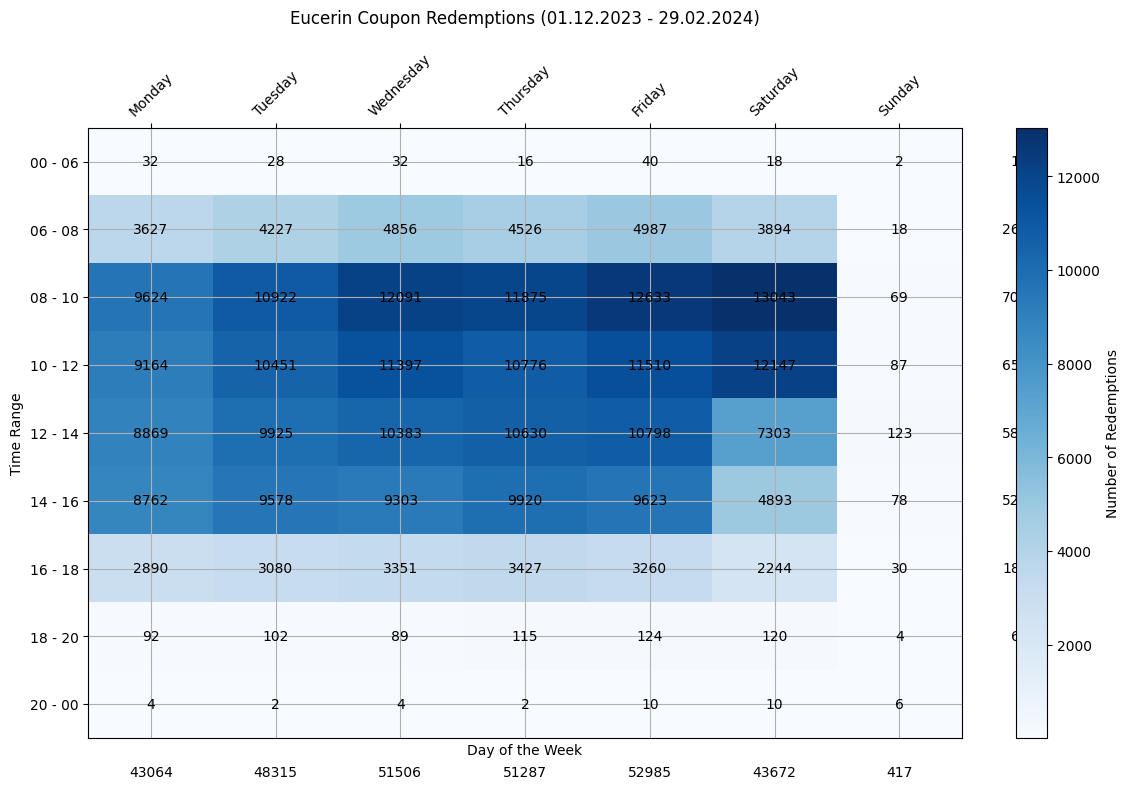

In [58]:
# Filter for "Eucerin" products in the dataset
eucerin_data = full_df[full_df['name'].str.contains('Eucerin', case=False, na=False)]

# Ensure `timestamp` is properly formatted
eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')

# Filter data for the specified date range: 01.12.2023 to 29.02.2024
start_date = "2023-12-01"
end_date = "2024-02-29"
eucerin_data = eucerin_data[(eucerin_data['timestamp'] >= start_date) & (eucerin_data['timestamp'] <= end_date)]


# Filter for "Eucerin" products in the dataset
eucerin_data = full_df[full_df['name'].str.contains('Eucerin', case=False, na=False)]

# Ensure `timestamp` is properly formatted
eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')

# Filter data for the specified date range: 01.12.2023 to 29.02.2024
start_date = "2023-12-01"
end_date = "2024-02-29"
eucerin_data = eucerin_data[(eucerin_data['timestamp'] >= start_date) & (eucerin_data['timestamp'] <= end_date)]

# Create the day_of_week column
eucerin_data['day_of_week'] = eucerin_data['timestamp'].dt.day_name()

# Define the order of the days, starting with Monday
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Ensure the 'day_of_week' column is ordered correctly
eucerin_data['day_of_week'] = pd.Categorical(eucerin_data['day_of_week'], categories=day_order, ordered=True)

# Define time range bins
time_bins = [0, 6, 8, 10, 12, 14, 16, 18, 20, 24]
time_labels = ["00 - 06", "06 - 08", "08 - 10", "10 - 12", "12 - 14", 
               "14 - 16", "16 - 18", "18 - 20", "20 - 00"]

# Add time_range column
eucerin_data['time_range'] = pd.cut(eucerin_data['timestamp'].dt.hour, bins=time_bins, labels=time_labels, right=False)

# Group data by time ranges and days of the week
redemption_summary = eucerin_data.groupby(['time_range', 'day_of_week']).size().unstack(fill_value=0)

# Add row and column totals
redemption_summary['Total'] = redemption_summary.sum(axis=1)
redemption_summary.loc['Total'] = redemption_summary.sum(axis=0)

# Separate data for the heatmap (excluding totals)
heatmap_data = redemption_summary.iloc[:-1, :-1]  # Exclude totals row and column
totals_row = redemption_summary.iloc[-1, :-1]  # Last row (total for columns)
totals_col = redemption_summary.iloc[:-1, -1]  # Last column (total for rows)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 8))

cax = ax.matshow(heatmap_data, cmap="Blues", aspect="auto")
plt.colorbar(cax, ax=ax, label="Number of Redemptions")

# Annotate the heatmap with values
for (i, j), value in np.ndenumerate(heatmap_data.values):
    ax.text(j, i, int(value), ha='center', va='center', color="black")

# Customize ticks and labels
ax.set_xticks(np.arange(len(heatmap_data.columns)))
ax.set_yticks(np.arange(len(heatmap_data.index)))
ax.set_xticklabels(heatmap_data.columns, rotation=45)
ax.set_yticklabels(heatmap_data.index)
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Time Range")
ax.set_title("Eucerin Coupon Redemptions (01.12.2023 - 29.02.2024)", pad=20)

# Add the total row below the heatmap
for j, total in enumerate(totals_row):
    plt.text(j, len(heatmap_data), int(total), ha='center', va='center', color="black", fontsize=10)
plt.text(len(totals_row), len(heatmap_data), " ", ha='center', va='center')

# Add the total column to the right of the heatmap
for i, total in enumerate(totals_col):
    plt.text(len(heatmap_data.columns), i, int(total), ha='center', va='center', color="black", fontsize=10)

# Hide unwanted ticks for aesthetics
ax.tick_params(axis="x", bottom=False, top=True, labeltop=True)
plt.tight_layout()
plt.show()


##### page 12

In [59]:

# Filter for "Eucerin" products
eucerin_data = full_df[full_df['name'].str.contains('Eucerin', case=False, na=False)]

# Ensure `timestamp` is properly formatted
eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')

# Filter data for the specified date range: 01.12.2023 to 29.02.2024
start_date = "2023-12-01"
end_date = "2024-02-29"
eucerin_data = eucerin_data[(eucerin_data['timestamp'] >= start_date) & (eucerin_data['timestamp'] <= end_date)]

# Group by GLN (pharmacy identifier) and count redemptions
top_pharmacies = eucerin_data.groupby('gln').size().reset_index(name='Redemptions')

# Sort by redemptions in descending order
top_pharmacies = top_pharmacies.sort_values(by='Redemptions', ascending=False)

# Select the top 20 pharmacies
top_20_pharmacies = top_pharmacies.head(20)

# Display the result
print(top_20_pharmacies)

top_20_pharmacies.to_csv('top_20_pharmacies.csv', index=False)


          gln  Redemptions
3299  2018952         2547
147   1009046         1934
240   1015327         1322
787   1054324         1309
2198  1171996         1274
1011  1070739         1168
1381  1101033         1115
763   1052416         1026
1833  1137473          970
3522  2033352          959
1013  1070880          911
1880  1142111          873
1603  1118445          867
2147  1168103          850
479   1032777          849
1790  1133573          835
2837  1237742          834
2043  1158268          812
337   1022858          812
1217  1087480          776


/tmp/ipykernel_650/3659901680.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')


In [60]:
import pandas as pd

# Filter for "Eucerin" products
eucerin_data = full_df[full_df['name'].str.contains('Eucerin', case=False, na=False)]

# Ensure `timestamp` is properly formatted
eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')

# Filter data for the specified date range: 01.12.2023 to 29.02.2024
start_date = "2023-12-01"
end_date = "2024-02-29"
eucerin_data = eucerin_data[(eucerin_data['timestamp'] >= start_date) & (eucerin_data['timestamp'] <= end_date)]

# Extract the first digit of the `zipcode_area` as the PLZ Gebiet
eucerin_data['PLZ_Gebiet'] = eucerin_data['zipcode_area'].astype(str).str[0]

# Explicitly include only PLZ Gebiet values from 0 to 9
eucerin_data = eucerin_data[eucerin_data['PLZ_Gebiet'].isin([str(i) for i in range(10)])]

# Group by PLZ Gebiet (first digit of the zipcode area) and count redemptions
zipcode_redemptions = eucerin_data.groupby('PLZ_Gebiet').size().reset_index(name='Redemptions')

# Sort by PLZ Gebiet in ascending order
zipcode_redemptions = zipcode_redemptions.sort_values(by='PLZ_Gebiet')

# Display the result
print(zipcode_redemptions)

# Save the result to a CSV file
zipcode_redemptions.to_csv('plz_0_to_9_redemptions.csv', index=False)

/tmp/ipykernel_650/1230072194.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eucerin_data['timestamp'] = pd.to_datetime(eucerin_data['timestamp'], errors='coerce')


  PLZ_Gebiet  Redemptions
0          0        20042
1          1        27105
2          2        61701
3          3        31465
4          4        24431
5          5        21185
6          6        26973
7          7        22307
8          8        37081
9          9        18956


-----------

## Bonus 1

#### identify brands in the product data && How much pzn numbers are linked to the brands?


In [49]:
import json

brands = ["Eucerin", "Vichy", "Sebamed", "Linola", "Roche Posay", "Kneipp", "Sinupret", "Bepanthen", "Thomapyrin", "Voltaren", "Doppelherz", "Iberogast", "Meditonsin", "Grippostad"]

brand_data = {}

for brand in brands:
    brand_lower = brand.lower()
    related_products = products_df[products_df['name'].str.lower().str.contains(brand_lower)]
    brand_data[brand] = {
        "count": len(related_products),
        "pzn": related_products['pzn'].tolist()
    }
    print(f"Number of products related to {brand}: {len(related_products)}")


# create a folder for the brand data if it does not exist
if not os.path.exists('bonus1'):
    os.makedirs('bonus1')

# Write the results to a JSON file
with open('brand_data.json', 'w') as f:
    json.dump(brand_data, f, indent=4)
    print("Brand data written to brand_data.json")


Number of products related to Eucerin: 185
Number of products related to Vichy: 306
Number of products related to Sebamed: 129
Number of products related to Linola: 68
Number of products related to Roche Posay: 317
Number of products related to Kneipp: 335
Number of products related to Sinupret: 14
Number of products related to Bepanthen: 17
Number of products related to Thomapyrin: 6
Number of products related to Voltaren: 32
Number of products related to Doppelherz: 335
Number of products related to Iberogast: 10
Number of products related to Meditonsin: 4
Number of products related to Grippostad: 12
Brand data written to brand_data.json


## Bonus 2

### Show the top10 of most sold PZNs

In [ ]:
# get the top 10 sold products basen on the quantity sold
top_10_products = full_df.groupby('pzn')['quantity'].sum().sort_values(ascending=False).head(10)
top_10_products = top_10_products.reset_index()
top_10_products = top_10_products.merge(products_df, on='pzn', how='inner')
print(top_10_products)

top_pnzs = top_10_products['pzn'].tolist()


#  simmple approach to confirm the the above code results
# # create a dict for prod-count
# product_count = {}
# # loop through full_df and count the number of times each product is sold
# for index, row in full_df.iterrows():
#     pzn = row['pzn']
#     if pzn in product_count:
#         product_count[pzn] += row['quantity']
#     else:
#         product_count[pzn] = row['quantity']

# # sort the dict by the values
# sorted_product_count = dict(sorted(product_count.items(), key=lambda item: item[1], reverse=True))

# # get the top 10 products
# top_10_products = list(sorted_product_count.items())[:10]
# print(top_10_products)

        pzn  quantity                        name
0  00999831    620564   NASENSPRAY RATIOPHARM ERW
1  03929274    364960          NASENSPRAY AL 0.1%
2  01126111    339355     PARACETAMOL RATIO 500MG
3  00571748    287599                GRIPPOSTAD C
4  00705309    194112            NASIC NASENSPRAY
5  02340421    177757                 OLYNTH 0.1%
6  01580241    155952  BEPANTHEN WUND U HEILSALBE
7  08585997    124148          PROSPAN HUSTENSAFT
8  01479157    122533            GELOMYRTOL FORTE
9  12550409    122460                FENISTIL GEL


<mark></mark>

 Choose one of it and analyze regional and time dependent price variations in comparison to the mean price.

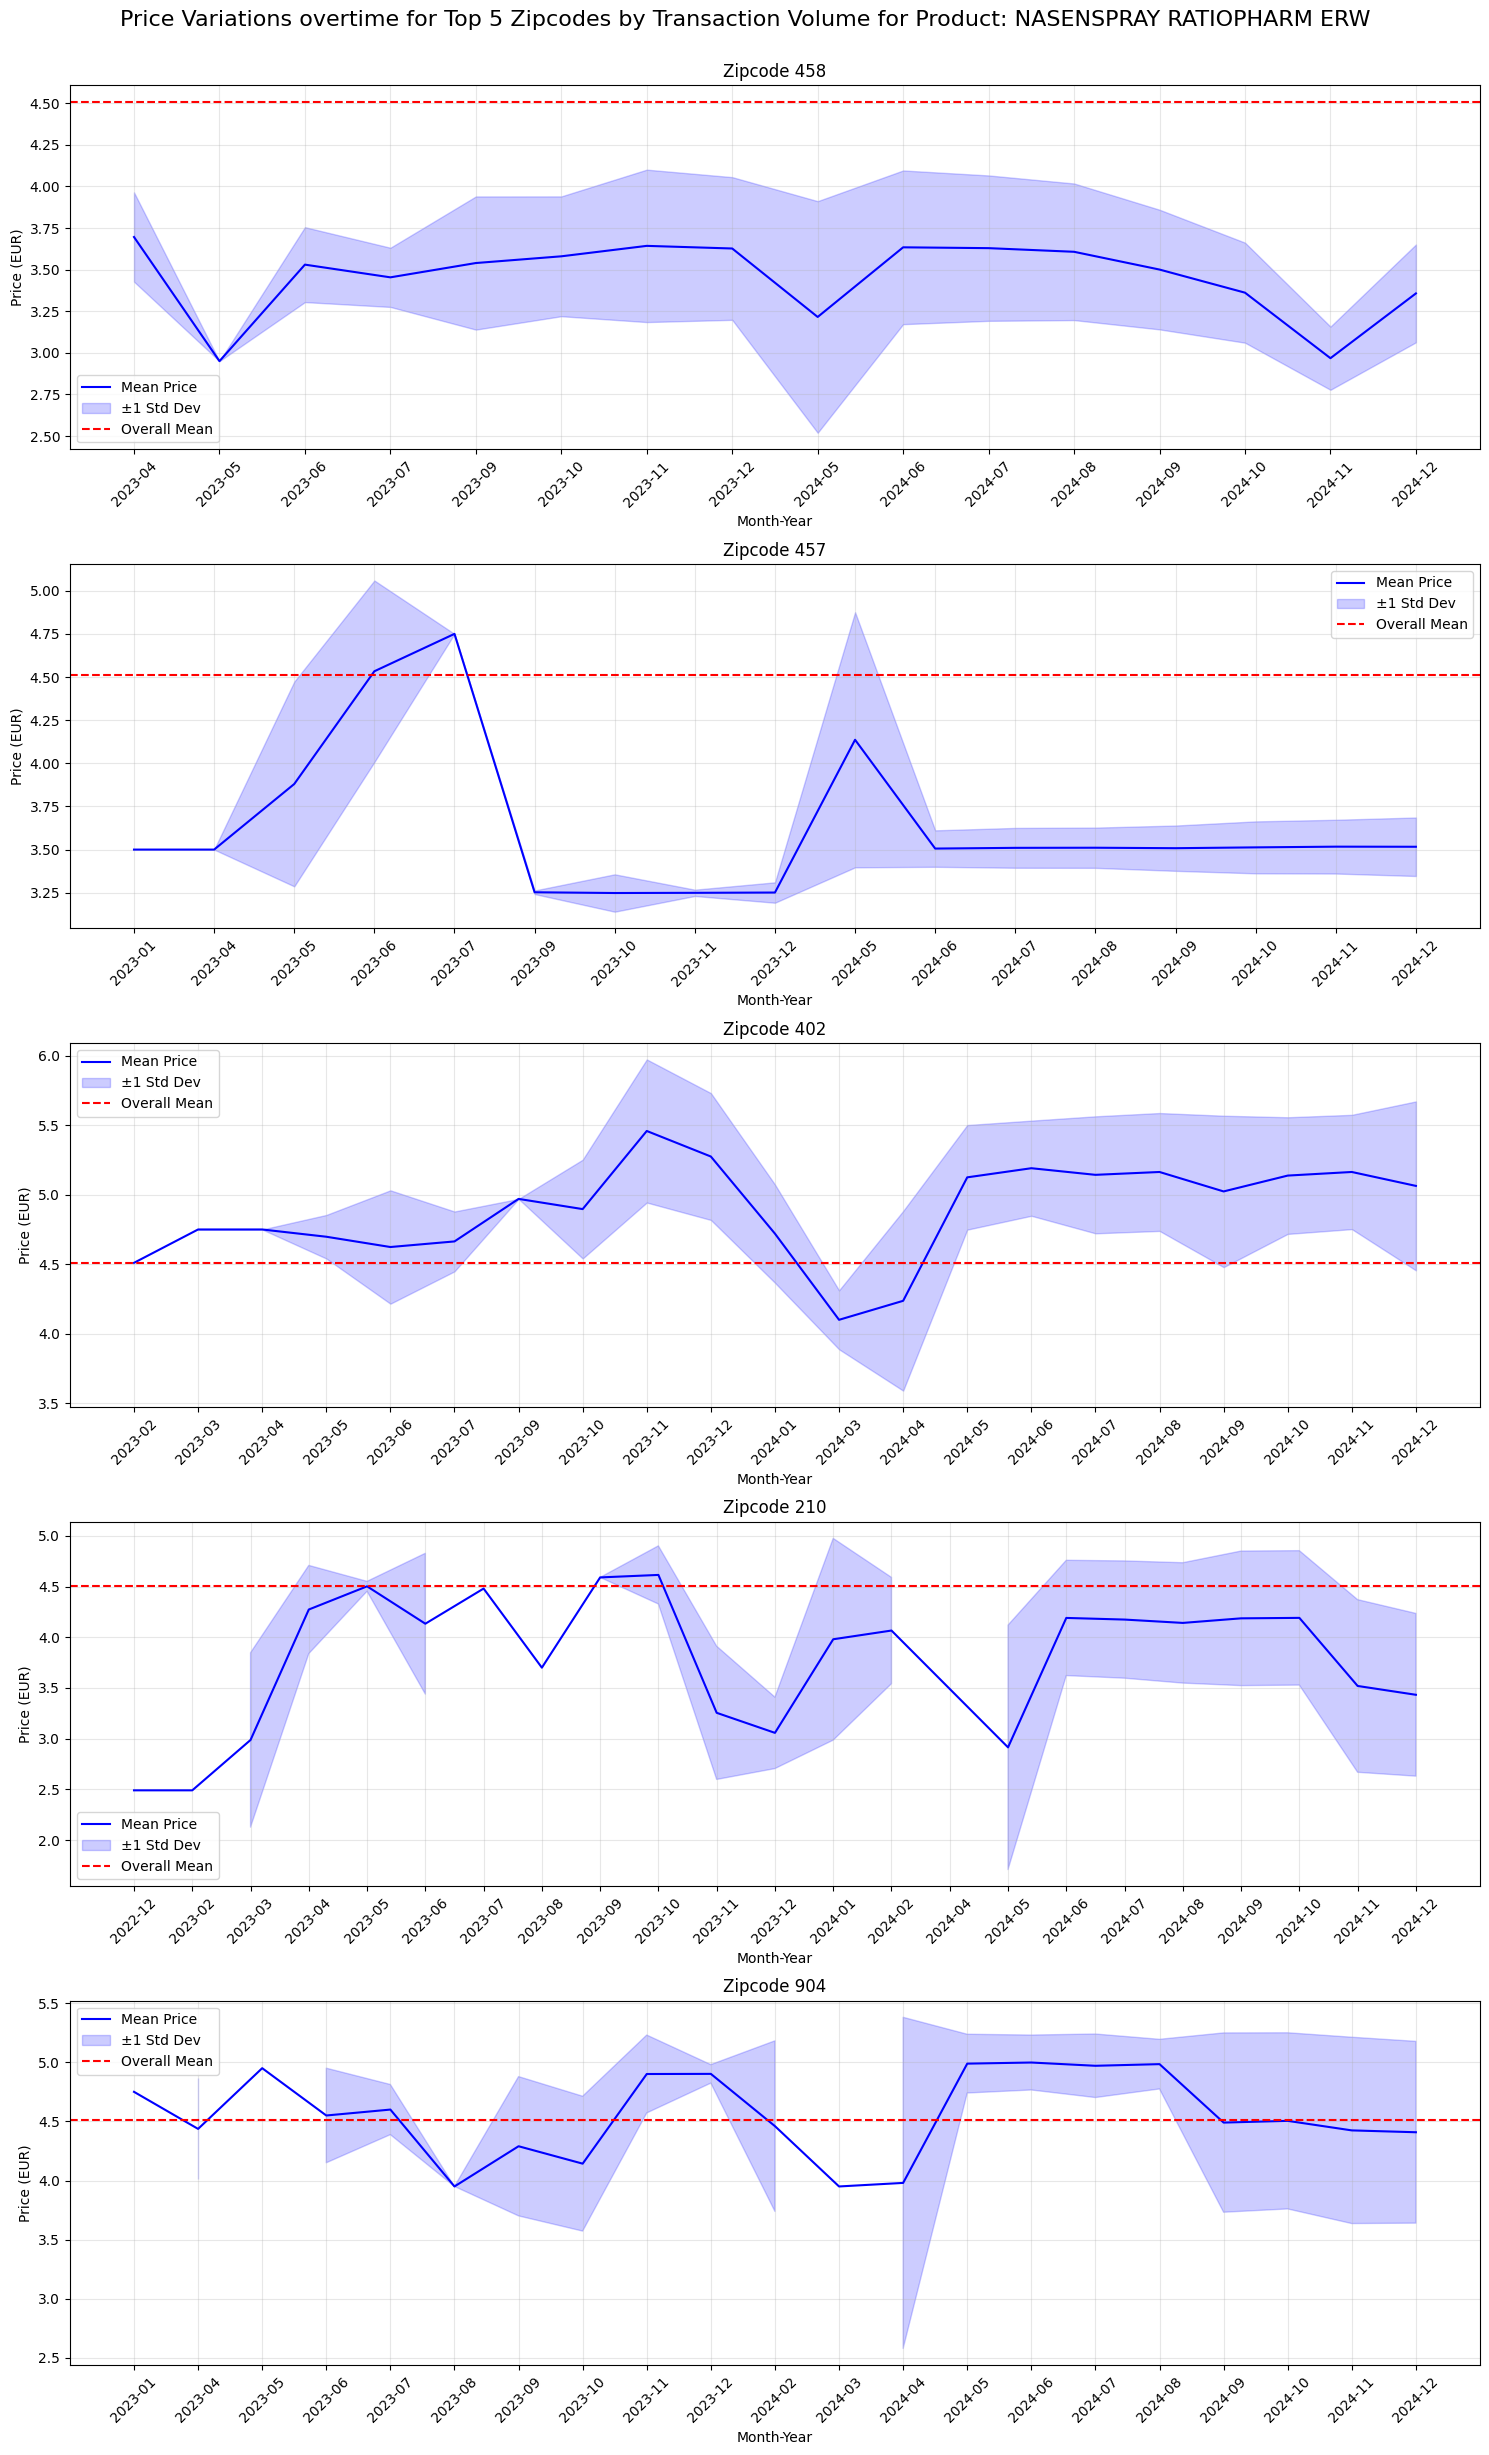

In [51]:
pzn_to_analyze = top_pnzs[0]
product_name = top_10_products[top_10_products['pzn'] == pzn_to_analyze]['name'].values[0]

# Get all transactions for this product
product_transactions = full_df[full_df['pzn'] == pzn_to_analyze].copy()

# change the amount to be the peice per item (because the amount is the total price for all the items)
product_transactions['amount'] = product_transactions['amount'] / product_transactions['quantity']

# Add month-year column for time analysis
product_transactions['month_year'] = product_transactions['timestamp'].dt.to_period('M')

# Calculate mean price per zipcode and month
    # mean price per zipcode and month
    # standard deviation of price per zipcode and month (to show price variations)
price_variations = product_transactions.groupby(['zipcode_area', 'month_year'])['amount'].agg(['mean', 'std']).reset_index()

# Calculate overall mean price
overall_mean = product_transactions['amount'].mean()

# Get top zipcodes by transaction volume
top_zipcodes = product_transactions['zipcode_area'].value_counts().head(5).index

# Create subplot for each zipcode
n_zips = len(top_zipcodes)
fig, axes = plt.subplots(n_zips, 1, figsize=(15, 5*n_zips))
fig.suptitle('Price Variations overtime for Top 5 Zipcodes by Transaction Volume for Product: ' + product_name, fontsize=16)

# Plot each zipcode separately
for idx, zipcode in enumerate(top_zipcodes):
    zipcode_data = price_variations[price_variations['zipcode_area'] == zipcode]
    
    # Plot mean price line
    axes[idx].plot(zipcode_data['month_year'].astype(str), 
                  zipcode_data['mean'], 
                  'b-', 
                  label='Mean Price')
    
    # Add standard deviation range
    axes[idx].fill_between(zipcode_data['month_year'].astype(str),
                          zipcode_data['mean'] - zipcode_data['std'],
                          zipcode_data['mean'] + zipcode_data['std'],
                          alpha=0.2,
                          color='b',
                          label='±1 Std Dev')
    
    # Add overall mean reference line
    axes[idx].axhline(y=overall_mean, 
                     color='r', 
                     linestyle='--', 
                     label='Overall Mean')
    
    # Customize each subplot
    axes[idx].set_title(f'Zipcode {zipcode}')
    axes[idx].set_xlabel('Month-Year')
    axes[idx].set_ylabel('Price (EUR)')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for the main title

# Show the plot
plt.show()